# Mounting your google drive

You can use google drive to store and access files e.g. storing and loading data from numpy or CSV files.  
Use the following command to mount your GDrive and access your files.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!pip install ffmpeg

In [ ]:
%matplotlib inline
import numpy as np
import os
import cv2
import pandas as pd
import scipy
import numpy.linalg as la
import scipy.linalg as sl
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt
import torch.nn as nn  # Neural network module
import scipy.sparse as sp
import scipy.optimize as sop
import progressbar
# making slopes
import torch
from torch.utils.data import TensorDataset
from matplotlib.pyplot import LinearLocator
import matplotlib as mpl
import matplotlib.colors as colors

# create an animation
from matplotlib import animation
from IPython.display import HTML

from matplotlib import animation
import math
import ffmpeg

!pip install pycm livelossplot
%pylab inline
from livelossplot import PlotLosses

from torch.utils.data import DataLoader
import torch.utils.data as Data

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cuda'  # Set out device to GPU

print('Cuda installed, running on GPU!')  # print sentence

Cuda installed, running on GPU!


# Functions

In [13]:
# This function is used to save save all plots to a folder
def Save_pic(path,x,S,name):
  Num = S.shape[1]
  for i in range(Num):
    fig = plt.figure(figsize=(6, 4))
    ax1 = fig.add_subplot(111)
    ax1.plot(x,S[:,i])
    ax1.set_xlim(-100,100)
    ax1.set_ylim(0,1)
    plt.savefig(path + name+ "_BE_"+str(i)+".jpg")

# This function is used to collect the pictures to a video
def picTovideo(picPath,videoPath,Num,name):
  fps = 24
  frame = cv2.imread(picPath + name+"_BE_0.jpg")
  print(frame.shape)
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  videoWriter = cv2.VideoWriter(videoPath +'.avi',fourcc,fps,(frame.shape[1],frame.shape[0]),True)
  
  for i in range(Num):
    frame = cv2.imread(picPath+name+"_BE_"+str(i+1)+'.jpg')
    # cv2.imshow('frame',frame)
    videoWriter.write(frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Save a array to csv
def saveNumpy(path, array):
    np.savetxt(path, array, delimiter=',')

# Load csv to a array
def getNumpy(path):
    array = np.loadtxt(path,delimiter=",")
    return array

# Split the total num randomly according to the ratio train_ratio:valid_ratio:test_ratio
def index_split(train_ratio, valid_ratio, test_ratio, total_num):
    if train_ratio + valid_ratio + test_ratio != 1:
        raise ValueError("Three input ratio should sum to be 1!")
    total_index = np.arange(total_num)
    rng = np.random.default_rng()
    total_index = rng.permutation(total_index)
    knot_1 = int(total_num * train_ratio)
    knot_2 = int(total_num * valid_ratio) + knot_1
    train_index, valid_index, test_index = np.split(total_index, [knot_1, knot_2])
    total_index = np.arange(total_num)

    return train_index, valid_index, test_index, total_index

# Save the indexs to the specifed path
def saveIndex(path_train, path_valid, path_test,path_total,train_index, valid_index, test_index,total_index):
    # save training and validation loss    
    np.savetxt(path_train,train_index, delimiter=',')
    np.savetxt(path_valid,valid_index, delimiter=',')
    np.savetxt(path_test,test_index, delimiter=',')
    np.savetxt(path_total,total_index, delimiter=',')

# load the indexes as the array
def getIndex(path_train,path_valid,path_test,path_total):
    train_index = np.loadtxt(path_train,delimiter=",")
    valid_index = np.loadtxt(path_valid,delimiter=",")
    test_index = np.loadtxt(path_test,delimiter=",")
    total_index = np.loadtxt(path_total,delimiter=",")
    return train_index,valid_index,test_index,total_index


# Burgers equation

For a given field $u(x,t)$ and diffusion coefficient (or kinematic viscosity, as in the original fluid mechanical context) $v$, the general form of Burgers' equation (also known as viscous Burgers' equation) in one space dimension is the dissipative system:
$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}=v\frac{\partial^2u}{\partial x^2}$$

where we have the following variables:

$x$: spatial coordinate

$t$: temporal coordinate

$u(x,t)$: speed of fluid at the indicated spatial and temporal coordinates

$v$: viscosity of fluid
<br>

As we've done before let's discretise in space first to yield a system of coupled ODEs (which gives us the system from the previous lecture, but with an updated velocity - $c$ rather than $u$):


\begin{align} 
\frac{\partial u_i}{\partial t} + u_i\frac{u_{i+1} - u_{i-1}}{2\Delta x}  &= \kappa\frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2}\\
 \text{or} \;\;\;\;\;\;\;
\frac{\partial u_i}{\partial t} &= - u_i\frac{u_{i+1} - u_{i-1}}{2\Delta x} + \kappa\frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2} . 
\end{align}


We can write the nonlinear ODE system as


$$\frac{d\boldsymbol{u}}{dt} = A(\boldsymbol{u}) \, \boldsymbol{u},$$


i.e. in a form where the discretisation (in space) matrix is itself a function of $c$,

where $\boldsymbol{u}$ is the vector of spatial approximations to the solution and where now

$$ A(u) := -\frac{\text{diag}(\boldsymbol{u})}{\Delta x} D_x + \frac{\kappa}{\Delta x^2}D_{xx},$$

where $\text{diag}(\boldsymbol{u})$ is the diagonal matrix with the entries of the vector $\boldsymbol{u}$ on the main diagonal.

<br>

Discretising in time with forward Euler yields

$$\frac{\boldsymbol{u}^{n+1} - \boldsymbol{u}^{n}}{\Delta t} = A(\boldsymbol{u}^{n})\boldsymbol{u}^{n} \;\;\;\;\;\iff \;\;\;\;\;
{\boldsymbol{u}^{n+1} = \boldsymbol{u}^{n}} + {\Delta t} A(\boldsymbol{u}^{n})\boldsymbol{u}^{n}. $$

In [6]:
#Define parameters
L = 200
n = 200
total_t = 300
delta_t = 1
delta_x = L/n
sigma = 0.01
v = 0.01

(200, 300)


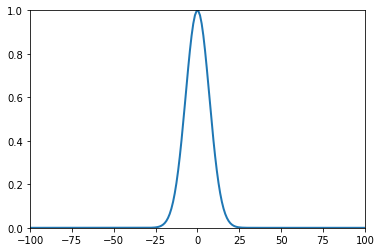

In [7]:
# Create matrices and figure
i_n = np.zeros((n,n))
np.fill_diagonal(i_n,1)
u_xx = np.zeros((n,n))
np.fill_diagonal(u_xx,-2)
np.fill_diagonal(u_xx[1:],1)  
np.fill_diagonal(u_xx[-1:],1) 
u_xx = u_xx*(v*delta_t/(delta_x**2))
fig = plt.figure()
ax = plt.axes(xlim=(-L/2, L/2), ylim=(0,1))  
line, = ax.plot([], [], lw=2)   

# define an initial condition (a Gaussian)
def Initial_Curve(x,rand_value):
    u = rand_value*(math.exp(-sigma*((x)**2)))
    return u

#Initialise start
def init():
    global u  
    x = np.linspace(-L/2,L/2,n)
    u = np.zeros((n,1))
    rand_value= 1
    for i in range (n):
        u[i] = [Initial_Curve(x[i],rand_value)]
    u[0] = 0
    u[n-1] = 0
    line.set_data(x,u)
    return u,x

#Create Non-linear matrix
def Create_u_u_xx(u):
    A = np.zeros((n,n))
    A[0,0] = u[0,0]
    j = 0
    for i in range(n-1):
        A[i+1,j] = -u[i+1,0]
        j = j +1
        A[i+1,j] = u[i+1,0]
    A = A*(delta_t/delta_x)
    return A

#Create matric and invert
def Create_i1(A):
    #i1 = i_n - A + u_xx
    i1 = i_n  + A - u_xx
    i1 = np.linalg.inv(i1)
    return i1

#Determine new velocity values
def Update_u(u):
    A = Create_u_u_xx(u)
    i1 = Create_i1(A)
    u = np.dot(np.dot(i1,i_n),u)
    #u = np.dot(i1,u)
    u[0] = 0
    u[n-1] = 0
    x = np.linspace(-L/2,L/2,n)
    #line.set_data(x,u)
    return u,x

#Determine S matrix
def S_Matrix():
    u,x = init()
    S = np.zeros((n,int(total_t/delta_t)))
    S[:,0] = u[:,0]
    for i in range(int(total_t/delta_t-1)):
        u,x = Update_u(u)
        S[:,i+1]=u[:,0]
    return S,x

#Update graph  
def Update_Graph(i):
    line.set_data(x,S[:,i])

# u,x = init()
# A = Create_u_u_xx(u)
# print(A)


#Create S and x
S,x = S_Matrix()
#Animate time-series
anim= animation.FuncAnimation(fig,Update_Graph,init_func=init,frames=total_t, interval=100)
print(S.shape)
plt.show()


In [8]:
HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [9]:
# Save the data of x and original S
# os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
# S,x = S_Matrix()    # 0 70 150
# pathx = "./BE_results/results_csv/x.csv"
# path_orginal = "./BE_results/results_csv/orginal.csv"
# saveNumpy(pathx,x)
# saveNumpy(path_orginal,S)

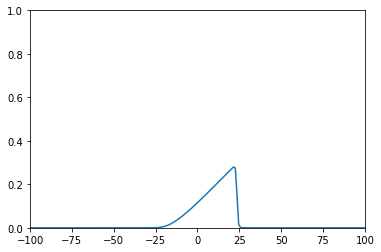

In [10]:
S,x = S_Matrix()    # 0 70 150
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)
ax1.set_xlim(-100,100)
ax1.set_ylim(0,1)
ax1.plot(x,S[:,70])

In [16]:
# Save the pictures of original data at each time step
# The path can be defined by the user
picPath = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/original_BE/"
Save_pic(picPath,x,S,'original')

Output hidden; open in https://colab.research.google.com to view.

In [17]:
videoPath = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/original_BE"
picTovideo(picPath,videoPath,300,'original')

(288, 432, 3)


## Index

In [ ]:
# Random split the index. The index of each part has been saved
# train_index,valid_index,test_index,total_index = index_split(0.8, 0.1, 0.1, 300)
# print(train_index.shape)
# print(valid_index.shape)
# print(valid_index.shape)
# print(total_index.shape)

In [19]:
# The path of each index. The user can defined by themself
path_train = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/"+"BE_train_index.csv"
path_valid = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/"+"BE_valid_index.csv"
path_test = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/"+"BE_test_index.csv"
path_total = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/"+"BE_total_index.csv"
# saveIndex(path_train, path_valid, path_test, path_total, train_index, valid_index, test_index, total_index)

In [20]:
# Load the indexes
train_index,valid_index,test_index, total_index= getIndex(path_train,path_valid,path_test,path_total)
print(train_index)
print(valid_index)
print(test_index)

[136.  62. 180. 286. 288. 153. 241. 211. 260. 249. 209. 292. 290.  72.
  44. 202. 110. 223. 285. 131. 111.   9.  75. 272. 266. 141. 174.   6.
 190.  35. 289.  31.  81. 115. 164. 224.   8. 246.  21.  63. 257. 299.
 140. 121.  29.  13. 233. 142. 172. 276.  48.  37. 254. 160. 228. 129.
 138. 199. 222.  79.  19. 102.  34. 130.   7.  27. 296.  86.  32.  11.
  76. 268.  66. 235.  67. 191. 169. 106. 212.  17.  99. 256. 128.  51.
 230. 162. 137. 171. 143. 270. 274. 158. 219.  41. 282. 135. 148. 187.
 168. 154. 214. 225. 125. 204. 109. 104.  39.  89. 255. 250.  77. 184.
 293.  52. 159. 226. 166.  98. 163. 261. 151. 145. 231. 133. 167. 242.
 298. 294.  80. 123. 112. 234. 122.  90. 185.  26.  85.  59.  18.  57.
   4. 181.  49.  36. 132. 194. 262. 192.  96. 183. 248.  87.  93. 179.
 207. 196. 220.  42. 232. 177. 258. 215. 280.  84.  33.  65.  97.  16.
  43. 281. 273. 116. 175. 165. 182. 271. 208. 124.   0.   1.  83. 213.
 134. 236. 221.  74. 200. 146. 253. 277.  25. 218. 291. 264. 103.  46.
 178. 

# Hierarchical autoencoder

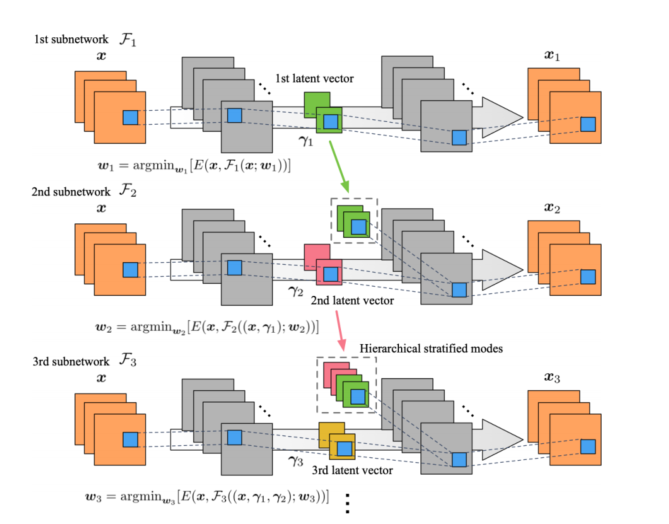

## Load data

In [154]:
# Generate the burgers equation solution
S,x = S_Matrix()
S = np.array(S)
print(S.shape)

# For the autoencoder, the solution must be arranged in a row vetor
S = S.transpose()
print(S.shape)

# The total data is divided into three parts
training_data = np.zeros([len(train_index),n])
for i in range(len(train_index)):
    training_data[i,:]= S[int(train_index[i]),:]


valid_data = np.zeros([len(valid_index),n])
for i in range(len(valid_index)):
    valid_data[i,:] = S[int(valid_index[i]),:]


test_data = np.zeros([len(test_index),n])
for i in range(len(test_index)):
    test_data[i,:] = S[int(test_index[i]),:]


total_data = np.zeros([len(total_index),n])
for i in range(len(total_index)):
    total_data[i,:] = S[i,:]

print("training data shape:",training_data.shape)
print("valid data shape:",valid_data.shape)
print("test data:",test_data.shape)
print('total data shape',total_data.shape)

(200, 300)
(300, 200)
training data shape: (240, 200)
valid data shape: (30, 200)
test data: (30, 200)
total data shape (300, 200)


## Networks

### First subnetwork

In [155]:
# The architecture of the first subnetwork
class CAE_1(nn.Module):
    def __init__(self,hidden_1):
        super(CAE_1,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1,8,3,3,15),
            nn.ReLU(),
            nn.Conv1d(8,16,3,3,15),
            nn.ReLU(),
            nn.Conv1d(16,16,3,3,15),
            nn.ReLU(),
        )
        self.fc1=nn.Sequential(
            nn.Linear(16*21,hidden_1),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_1,16*21),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(16,16,3,3,14),
            nn.ReLU(),
            nn.ConvTranspose1d(16,8,4,3,15),
            nn.ReLU(),
            nn.ConvTranspose1d(8,1,3,3,14),
            nn.ReLU(),
        )

    def forward(self,x):
        encoded_1 = self.encoder(x.view(-1,1,200))
        encoded = self.fc1(encoded_1.view(-1,16*21))
        decoded_1 = self.fc2(encoded)
        decoded = self.decoder(decoded_1.view(-1,16,21)).view(-1,200)
        
        return encoded,decoded

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv1d') != -1:
        # Apply kaiming initialization to Conv1d layer
        nn.init.constant_(m.bias.data, 0)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif classname.find('Linear') != -1:
        # Apply xavier initialization to Linear layer
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias.data, 0.05)
    elif classname.find('ConvTranspose1d') != -1:
        # Apply kaiming initialization to ConvTranspose1d layer
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0.05)

### Second subnetwork

In [156]:
# The second network architecture 
class CAE_2(nn.Module):
    def __init__(self,hidden_2):
        super(CAE_2,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1,16,3,2,5),
            nn.ReLU(),
            nn.Conv1d(16,16,3,2,5),
            nn.ReLU(),
            nn.Conv1d(16,16,3,2,5),
            nn.ReLU(),
        )
        self.fc1=nn.Sequential(
            nn.Linear(16*32,hidden_2),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(2*hidden_2,16*32),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(16,16,4,2,5),
            nn.ReLU(),
            nn.ConvTranspose1d(16,16,4,2,5),
            nn.ReLU(),
            nn.ConvTranspose1d(16,1,4,2,5),
            nn.ReLU(),
        )

    def forward(self,x,mode):
        encoded_1 = self.encoder(x.view(-1,1,200))
        encoded = self.fc1(encoded_1.view(-1,16*32))
        encoded = torch.cat((encoded, mode),axis = 1)
        decoded_1 = self.fc2(encoded)
        decoded = self.decoder(decoded_1.view(-1,16,32)).view(-1,200)
        
        return encoded,decoded

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv1d') != -1:
        # Apply kaiming initialization to Conv1d layer
        nn.init.constant_(m.bias.data, 0)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif classname.find('Linear') != -1:
        # Apply xavier initialization to Linear layer
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias.data, 0.05)
    elif classname.find('ConvTranspose1d') != -1:
        # Apply kaiming initialization to ConvTranspose1d layer
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0.05)

## Train

Run 10 times and choose the best value to record it

### Variable 2

#### Train first

In [157]:
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3000
BATCH_SIZE = 16
LR = 0.0001
print(training_data.shape)

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle=True)

(240, 200)


In [ ]:
# setup_seed(1)
t_train_0 = time.time()
autoencoder = CAE_1(1).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

t_train_1 = time.time()

Epoch:  0 | train loss: 0.011158 | valid loss: 0.005266
Epoch:  1 | train loss: 0.009323 | valid loss: 0.004910
Epoch:  2 | train loss: 0.002609 | valid loss: 0.004616
Epoch:  3 | train loss: 0.009072 | valid loss: 0.004363
Epoch:  4 | train loss: 0.007521 | valid loss: 0.004139
Epoch:  5 | train loss: 0.001712 | valid loss: 0.003963
Epoch:  6 | train loss: 0.001720 | valid loss: 0.003815
Epoch:  7 | train loss: 0.010479 | valid loss: 0.003694
Epoch:  8 | train loss: 0.006046 | valid loss: 0.003593
Epoch:  9 | train loss: 0.004062 | valid loss: 0.003506
Epoch:  10 | train loss: 0.005981 | valid loss: 0.003434
Epoch:  11 | train loss: 0.005495 | valid loss: 0.003373
Epoch:  12 | train loss: 0.002507 | valid loss: 0.003321
Epoch:  13 | train loss: 0.009886 | valid loss: 0.003274
Epoch:  14 | train loss: 0.004406 | valid loss: 0.003235
Epoch:  15 | train loss: 0.008615 | valid loss: 0.003197
Epoch:  16 | train loss: 0.005441 | valid loss: 0.003165
Epoch:  17 | train loss: 0.008401 | valid

In [ ]:
train_encoded1, train_decoded1 = autoencoder(torch.tensor(training_data).float().to(device))
train_error_autoencoder1 = (train_decoded1.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder1**2).mean())

valid_encoded1, valid_decoded1 = autoencoder(torch.tensor(valid_data).float().to(device))
valid_error_autoencoder1 = (valid_decoded1.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder1**2).mean())

test_encoded1, test_decoded1 = autoencoder(torch.tensor(test_data).float().to(device))
test_error_autoencoder1 = (test_decoded1.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder1**2).mean())

total_encoded1, total_decoded1 = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder1 = (total_decoded1.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder1**2).mean())

Train MSE:  8.676352071463061e-06
valid MSE:  5.0030965216854826e-06
Test MSE:  1.094919158372795e-05
Total MSE:  8.536310467711794e-06


#### Train second

In [160]:

# torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3000
BATCH_SIZE = 16
LR = 0.0001
print(training_data.shape)

train_set = TensorDataset(torch.from_numpy(training_data), train_encoded1)
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size = BATCH_SIZE, shuffle=True)

(240, 200)


In [ ]:
# setup_seed(1)
t_train_2 = time.time()
autoencoder_2 = CAE_2(1).to(device)
optimizer = torch.optim.Adam(autoencoder_2.parameters(), lr=LR)
autoencoder_2.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for x, mode in train_loader:
        detach_mode = mode.detach()
        b_mode = detach_mode.to(device)  #b_mode = True  #The size is [16,128]
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder_2(b_x.float(),b_mode.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder_2(torch.tensor(valid_data).float().to(device),valid_encoded1.float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)
t_train_3 = time.time()

Epoch:  0 | train loss: 0.017838 | valid loss: 0.014899
Epoch:  1 | train loss: 0.009542 | valid loss: 0.010795
Epoch:  2 | train loss: 0.011950 | valid loss: 0.008005
Epoch:  3 | train loss: 0.012228 | valid loss: 0.006145
Epoch:  4 | train loss: 0.009110 | valid loss: 0.004980
Epoch:  5 | train loss: 0.009520 | valid loss: 0.004246
Epoch:  6 | train loss: 0.008191 | valid loss: 0.003786
Epoch:  7 | train loss: 0.008902 | valid loss: 0.003497
Epoch:  8 | train loss: 0.002009 | valid loss: 0.003302
Epoch:  9 | train loss: 0.006572 | valid loss: 0.003166
Epoch:  10 | train loss: 0.005875 | valid loss: 0.003067
Epoch:  11 | train loss: 0.005063 | valid loss: 0.002988
Epoch:  12 | train loss: 0.007123 | valid loss: 0.002924
Epoch:  13 | train loss: 0.002871 | valid loss: 0.002860
Epoch:  14 | train loss: 0.003134 | valid loss: 0.002801
Epoch:  15 | train loss: 0.002603 | valid loss: 0.002740
Epoch:  16 | train loss: 0.006886 | valid loss: 0.002679
Epoch:  17 | train loss: 0.003066 | valid

In [ ]:
print("Train time: ", t_train_1- t_train_0+ t_train_3-t_train_2)

Train time:  342.76092314720154


In [ ]:
t_pre_0 = time.time()
train_encoded2, train_decoded2 = autoencoder_2(torch.tensor(training_data).float().to(device),train_encoded1.float().to(device))
train_error_autoencoder2 = (train_decoded2.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder2**2).mean())

valid_encoded2, valid_decoded2 = autoencoder_2(torch.tensor(valid_data).float().to(device),valid_encoded1.float().to(device))
valid_error_autoencoder2 = (valid_decoded2.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder2**2).mean())

test_encoded2, test_decoded2 = autoencoder_2(torch.tensor(test_data).float().to(device),test_encoded1.float().to(device))
test_error_autoencoder2 = (test_decoded2.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder2**2).mean())
t_pre_1 = time.time()

total_encoded2, total_decoded2 = autoencoder_2(torch.tensor(total_data).float().to(device),total_encoded1.float().to(device))
total_error_autoencoder2 = (total_decoded2.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder2**2).mean())

print("Reconstruction time: ", t_pre_1- t_pre_0)

Train MSE:  1.8115155949797702e-06
valid MSE:  1.5590795622657911e-06
Test MSE:  2.913574296777511e-06
Total MSE:  1.8964778618881469e-06
Reconstruction time:  0.012163877487182617


In [ ]:
total_decoded2 = total_decoded2.cpu().detach().numpy().transpose()
print(total_decoded2.shape)
os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
path = "./BE_results/results_csv/HAE_2.csv"
saveNumpy(path,total_decoded2)

(200, 300)


Text(0, 0.5, '$MSE loss$')

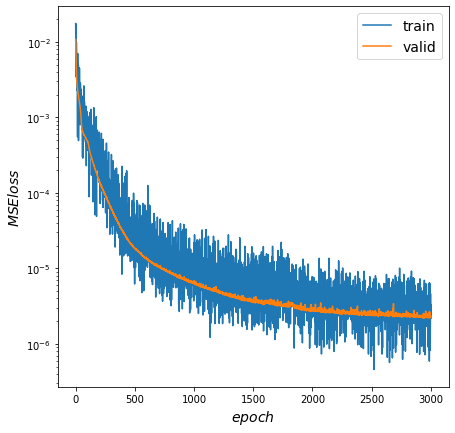

In [ ]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


In [168]:
# Save the pictures of total_decoded2 and using these pictures to generate video
S,x = S_Matrix()
total_decoded2 = total_decoded2.cpu().detach().numpy().transpose()
print(total_decoded2.shape)
picPath = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/HAE_BE/"
Save_pic(picPath,x,total_decoded2,'HAE')
videoPath = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/HAE_BE_2variable"
picTovideo(picPath,videoPath,300,'HAE')

Output hidden; open in https://colab.research.google.com to view.

### Variable 4

#### Train first

In [ ]:

torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3000
BATCH_SIZE = 16
LR = 0.0001
print(training_data.shape) 

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle=True)

(240, 200)


In [ ]:
# setup_seed(1)
t_train_0 = time.time()
autoencoder = CAE_1(2).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

t_train_1 = time.time()

Epoch:  0 | train loss: 0.005388 | valid loss: 0.003975
Epoch:  1 | train loss: 0.004671 | valid loss: 0.003799
Epoch:  2 | train loss: 0.002283 | valid loss: 0.003666
Epoch:  3 | train loss: 0.002362 | valid loss: 0.003541
Epoch:  4 | train loss: 0.006697 | valid loss: 0.003446
Epoch:  5 | train loss: 0.002561 | valid loss: 0.003378
Epoch:  6 | train loss: 0.003070 | valid loss: 0.003326
Epoch:  7 | train loss: 0.003666 | valid loss: 0.003283
Epoch:  8 | train loss: 0.003151 | valid loss: 0.003248
Epoch:  9 | train loss: 0.005605 | valid loss: 0.003216
Epoch:  10 | train loss: 0.003813 | valid loss: 0.003187
Epoch:  11 | train loss: 0.003784 | valid loss: 0.003161
Epoch:  12 | train loss: 0.004539 | valid loss: 0.003138
Epoch:  13 | train loss: 0.004649 | valid loss: 0.003091
Epoch:  14 | train loss: 0.008494 | valid loss: 0.003065
Epoch:  15 | train loss: 0.005424 | valid loss: 0.003046
Epoch:  16 | train loss: 0.009843 | valid loss: 0.003030
Epoch:  17 | train loss: 0.008166 | valid

In [ ]:
train_encoded1, train_decoded1 = autoencoder(torch.tensor(training_data).float().to(device))
train_error_autoencoder1 = (train_decoded1.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder1**2).mean())

valid_encoded1, valid_decoded1 = autoencoder(torch.tensor(valid_data).float().to(device))
valid_error_autoencoder1 = (valid_decoded1.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder1**2).mean())

test_encoded1, test_decoded1 = autoencoder(torch.tensor(test_data).float().to(device))
test_error_autoencoder1 = (test_decoded1.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder1**2).mean())

total_encoded1, total_decoded1 = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder1 = (total_decoded1.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder1**2).mean())

Train MSE:  0.0020882152711714686
valid MSE:  0.0011262542921726731
Test MSE:  0.0024997525352114702
Total MSE:  0.002033172899675589


#### Train second

In [ ]:
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3000
BATCH_SIZE = 16
LR = 0.0001
print(training_data.shape)

train_set = TensorDataset(torch.from_numpy(training_data), train_encoded1)
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size = BATCH_SIZE, shuffle=True)

(240, 200)


In [ ]:
# setup_seed(1)
t_train_2 = time.time()
autoencoder_2 = CAE_2(2).to(device)
optimizer = torch.optim.Adam(autoencoder_2.parameters(), lr=LR)
autoencoder_2.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for x, mode in train_loader:
        detach_mode = mode.detach()
        b_mode = detach_mode.to(device)  #b_mode = True  #The size is [16,128]
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder_2(b_x.float(),b_mode.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder_2(torch.tensor(valid_data).float().to(device),valid_encoded1.float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)
t_train_3 = time.time()

Epoch:  0 | train loss: 0.015750 | valid loss: 0.008314
Epoch:  1 | train loss: 0.010251 | valid loss: 0.006550
Epoch:  2 | train loss: 0.008517 | valid loss: 0.005311
Epoch:  3 | train loss: 0.002183 | valid loss: 0.004471
Epoch:  4 | train loss: 0.011397 | valid loss: 0.003913
Epoch:  5 | train loss: 0.007110 | valid loss: 0.003515
Epoch:  6 | train loss: 0.007156 | valid loss: 0.003238
Epoch:  7 | train loss: 0.004348 | valid loss: 0.003036
Epoch:  8 | train loss: 0.005672 | valid loss: 0.002881
Epoch:  9 | train loss: 0.005230 | valid loss: 0.002752
Epoch:  10 | train loss: 0.005360 | valid loss: 0.002646
Epoch:  11 | train loss: 0.002114 | valid loss: 0.002544
Epoch:  12 | train loss: 0.004053 | valid loss: 0.002456
Epoch:  13 | train loss: 0.008860 | valid loss: 0.002374
Epoch:  14 | train loss: 0.000966 | valid loss: 0.002292
Epoch:  15 | train loss: 0.009473 | valid loss: 0.002218
Epoch:  16 | train loss: 0.002330 | valid loss: 0.002148
Epoch:  17 | train loss: 0.002508 | valid

In [ ]:
print("Train time: ", t_train_1- t_train_0+ t_train_3-t_train_2)

Train time:  349.53594493865967


In [ ]:
t_pre_0 = time.time()
train_encoded2, train_decoded2 = autoencoder_2(torch.tensor(training_data).float().to(device),train_encoded1.float().to(device))
train_error_autoencoder2 = (train_decoded2.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder2**2).mean())

valid_encoded2, valid_decoded2 = autoencoder_2(torch.tensor(valid_data).float().to(device),valid_encoded1.float().to(device))
valid_error_autoencoder2 = (valid_decoded2.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder2**2).mean())

test_encoded2, test_decoded2 = autoencoder_2(torch.tensor(test_data).float().to(device),test_encoded1.float().to(device))
test_error_autoencoder2 = (test_decoded2.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder2**2).mean())
t_pre_1 = time.time()

total_encoded2, total_decoded2 = autoencoder_2(torch.tensor(total_data).float().to(device),total_encoded1.float().to(device))
total_error_autoencoder2 = (total_decoded2.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder2**2).mean())

print("Reconstruction time: ", t_pre_1- t_pre_0)

Train MSE:  2.6095779258248553e-06
valid MSE:  1.7115805823165355e-06
Test MSE:  3.238254097164158e-06
Total MSE:  2.5826458086079547e-06
Reconstruction time:  0.008865118026733398


Text(0, 0.5, '$MSE loss$')

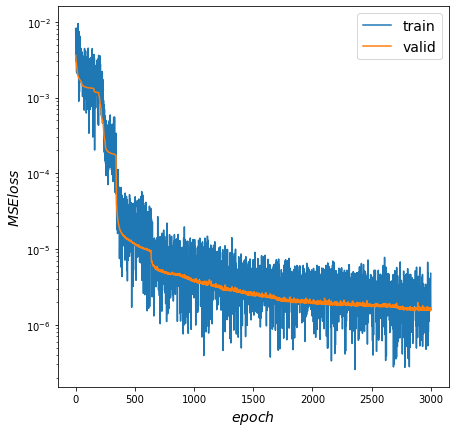

In [ ]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


### Variable 6

#### Train first

In [ ]:
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3000
BATCH_SIZE = 16
LR = 0.0001
print(training_data.shape) 

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle=True)

(240, 200)


In [ ]:
# setup_seed(1)
t_train_0 = time.time()
autoencoder = CAE_1(3).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

t_train_1 = time.time()

Epoch:  0 | train loss: 0.004152 | valid loss: 0.005259
Epoch:  1 | train loss: 0.004822 | valid loss: 0.004900
Epoch:  2 | train loss: 0.006927 | valid loss: 0.004596
Epoch:  3 | train loss: 0.007515 | valid loss: 0.004342
Epoch:  4 | train loss: 0.004856 | valid loss: 0.004133
Epoch:  5 | train loss: 0.010397 | valid loss: 0.003955
Epoch:  6 | train loss: 0.005868 | valid loss: 0.003812
Epoch:  7 | train loss: 0.002809 | valid loss: 0.003693
Epoch:  8 | train loss: 0.003758 | valid loss: 0.003593
Epoch:  9 | train loss: 0.006695 | valid loss: 0.003508
Epoch:  10 | train loss: 0.003627 | valid loss: 0.003435
Epoch:  11 | train loss: 0.006360 | valid loss: 0.003368
Epoch:  12 | train loss: 0.005906 | valid loss: 0.003309
Epoch:  13 | train loss: 0.011949 | valid loss: 0.003252
Epoch:  14 | train loss: 0.002885 | valid loss: 0.003202
Epoch:  15 | train loss: 0.008773 | valid loss: 0.003155
Epoch:  16 | train loss: 0.010465 | valid loss: 0.003111
Epoch:  17 | train loss: 0.008492 | valid

In [ ]:
train_encoded1, train_decoded1 = autoencoder(torch.tensor(training_data).float().to(device))
train_error_autoencoder1 = (train_decoded1.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder1**2).mean())

valid_encoded1, valid_decoded1 = autoencoder(torch.tensor(valid_data).float().to(device))
valid_error_autoencoder1 = (valid_decoded1.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder1**2).mean())

test_encoded1, test_decoded1 = autoencoder(torch.tensor(test_data).float().to(device))
test_error_autoencoder1 = (test_decoded1.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder1**2).mean())

total_encoded1, total_decoded1 = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder1 = (total_decoded1.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder1**2).mean())

Train MSE:  2.9505639258200343e-06
valid MSE:  2.6899932246443393e-06
Test MSE:  5.061885254451433e-06
Total MSE:  3.135638988565605e-06


#### Train second

In [ ]:
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3000
BATCH_SIZE = 16
LR = 0.0001
print(training_data.shape) # nTrain by number of nodes by 5

train_set = TensorDataset(torch.from_numpy(training_data), train_encoded1)
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size = BATCH_SIZE, shuffle=True)

(240, 200)


In [ ]:
# setup_seed(1)
t_train_2 = time.time()
autoencoder_2 = CAE_2(3).to(device)
optimizer = torch.optim.Adam(autoencoder_2.parameters(), lr=LR)
autoencoder_2.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for x, mode in train_loader:
        detach_mode = mode.detach()
        b_mode = detach_mode.to(device)  #b_mode = True  #The size is [16,128]
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder_2(b_x.float(),b_mode.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder_2(torch.tensor(valid_data).float().to(device),valid_encoded1.float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)
t_train_3 = time.time()

Epoch:  0 | train loss: 0.029276 | valid loss: 0.022379
Epoch:  1 | train loss: 0.021373 | valid loss: 0.015782
Epoch:  2 | train loss: 0.019299 | valid loss: 0.011308
Epoch:  3 | train loss: 0.010572 | valid loss: 0.008284
Epoch:  4 | train loss: 0.008080 | valid loss: 0.006230
Epoch:  5 | train loss: 0.012266 | valid loss: 0.004913
Epoch:  6 | train loss: 0.009276 | valid loss: 0.004022
Epoch:  7 | train loss: 0.009721 | valid loss: 0.003400
Epoch:  8 | train loss: 0.009385 | valid loss: 0.002948
Epoch:  9 | train loss: 0.009098 | valid loss: 0.002605
Epoch:  10 | train loss: 0.004303 | valid loss: 0.002330
Epoch:  11 | train loss: 0.005293 | valid loss: 0.002108
Epoch:  12 | train loss: 0.005985 | valid loss: 0.001931
Epoch:  13 | train loss: 0.001842 | valid loss: 0.001774
Epoch:  14 | train loss: 0.001592 | valid loss: 0.001635
Epoch:  15 | train loss: 0.006215 | valid loss: 0.001504
Epoch:  16 | train loss: 0.002108 | valid loss: 0.001391
Epoch:  17 | train loss: 0.001889 | valid

In [ ]:
print("Train time: ", t_train_1- t_train_0+ t_train_3-t_train_2)

Train time:  335.6835837364197


In [ ]:
t_pre_0 = time.time()
train_encoded2, train_decoded2 = autoencoder_2(torch.tensor(training_data).float().to(device),train_encoded1.float().to(device))
train_error_autoencoder2 = (train_decoded2.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder2**2).mean())

valid_encoded2, valid_decoded2 = autoencoder_2(torch.tensor(valid_data).float().to(device),valid_encoded1.float().to(device))
valid_error_autoencoder2 = (valid_decoded2.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder2**2).mean())

test_encoded2, test_decoded2 = autoencoder_2(torch.tensor(test_data).float().to(device),test_encoded1.float().to(device))
test_error_autoencoder2 = (test_decoded2.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder2**2).mean())
t_pre_1 = time.time()

total_encoded2, total_decoded2 = autoencoder_2(torch.tensor(total_data).float().to(device),total_encoded1.float().to(device))
total_error_autoencoder2 = (total_decoded2.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder2**2).mean())

print("Reconstruction time: ", t_pre_1- t_pre_0)

Train MSE:  5.954824125490701e-06
valid MSE:  5.382527689324245e-06
Test MSE:  5.9702002614998e-06
Total MSE:  5.899132095474966e-06
Reconstruction time:  0.010631322860717773


Text(0, 0.5, '$MSE loss$')

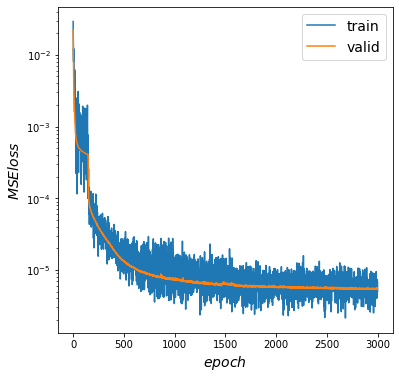

In [ ]:
fig = plt.figure(figsize=(6,6))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


### Variable 10

#### Train first

In [ ]:

torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3000
BATCH_SIZE = 16
LR = 0.0001
print(training_data.shape)

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle=True)

(240, 200)


In [ ]:
# setup_seed(1)
t_train_0 = time.time()
autoencoder = CAE_1(5).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

t_train_1 = time.time()

Epoch:  0 | train loss: 0.006678 | valid loss: 0.003508
Epoch:  1 | train loss: 0.005404 | valid loss: 0.003361
Epoch:  2 | train loss: 0.001673 | valid loss: 0.003264
Epoch:  3 | train loss: 0.003697 | valid loss: 0.003191
Epoch:  4 | train loss: 0.001038 | valid loss: 0.003142
Epoch:  5 | train loss: 0.004107 | valid loss: 0.003097
Epoch:  6 | train loss: 0.006877 | valid loss: 0.003054
Epoch:  7 | train loss: 0.005072 | valid loss: 0.003008
Epoch:  8 | train loss: 0.009241 | valid loss: 0.002955
Epoch:  9 | train loss: 0.003679 | valid loss: 0.002903
Epoch:  10 | train loss: 0.003696 | valid loss: 0.002845
Epoch:  11 | train loss: 0.003142 | valid loss: 0.002791
Epoch:  12 | train loss: 0.004525 | valid loss: 0.002734
Epoch:  13 | train loss: 0.005874 | valid loss: 0.002668
Epoch:  14 | train loss: 0.004297 | valid loss: 0.002601
Epoch:  15 | train loss: 0.003637 | valid loss: 0.002535
Epoch:  16 | train loss: 0.003096 | valid loss: 0.002482
Epoch:  17 | train loss: 0.008984 | valid

In [ ]:
train_encoded1, train_decoded1 = autoencoder(torch.tensor(training_data).float().to(device))
train_error_autoencoder1 = (train_decoded1.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder1**2).mean())

valid_encoded1, valid_decoded1 = autoencoder(torch.tensor(valid_data).float().to(device))
valid_error_autoencoder1 = (valid_decoded1.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder1**2).mean())

test_encoded1, test_decoded1 = autoencoder(torch.tensor(test_data).float().to(device))
test_error_autoencoder1 = (test_decoded1.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder1**2).mean())

total_encoded1, total_decoded1 = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder1 = (total_decoded1.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder1**2).mean())

Train MSE:  6.341482517154239e-06
valid MSE:  4.994149760312778e-06
Test MSE:  8.003462258436581e-06
Total MSE:  6.3729473242204265e-06


#### Train second

In [ ]:
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3000
BATCH_SIZE = 16
LR = 0.0001
print(training_data.shape) 

train_set = TensorDataset(torch.from_numpy(training_data), train_encoded1)
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size = BATCH_SIZE, shuffle=True)

(240, 200)


In [ ]:
# setup_seed(1)
t_train_2 = time.time()
autoencoder_2 = CAE_2(5).to(device)
optimizer = torch.optim.Adam(autoencoder_2.parameters(), lr=LR)
autoencoder_2.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for x, mode in train_loader:
        detach_mode = mode.detach()
        b_mode = detach_mode.to(device)  #b_mode = True  #The size is [16,128]
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder_2(b_x.float(),b_mode.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder_2(torch.tensor(valid_data).float().to(device),valid_encoded1.float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)
t_train_3 = time.time()

Epoch:  0 | train loss: 0.035426 | valid loss: 0.032663
Epoch:  1 | train loss: 0.026070 | valid loss: 0.023358
Epoch:  2 | train loss: 0.026518 | valid loss: 0.016906
Epoch:  3 | train loss: 0.022381 | valid loss: 0.012537
Epoch:  4 | train loss: 0.011127 | valid loss: 0.009436
Epoch:  5 | train loss: 0.020570 | valid loss: 0.007352
Epoch:  6 | train loss: 0.014415 | valid loss: 0.005905
Epoch:  7 | train loss: 0.007442 | valid loss: 0.004888
Epoch:  8 | train loss: 0.008032 | valid loss: 0.004200
Epoch:  9 | train loss: 0.006636 | valid loss: 0.003682
Epoch:  10 | train loss: 0.002232 | valid loss: 0.003285
Epoch:  11 | train loss: 0.002636 | valid loss: 0.002970
Epoch:  12 | train loss: 0.004036 | valid loss: 0.002716
Epoch:  13 | train loss: 0.004315 | valid loss: 0.002498
Epoch:  14 | train loss: 0.002301 | valid loss: 0.002329
Epoch:  15 | train loss: 0.001766 | valid loss: 0.002202
Epoch:  16 | train loss: 0.005999 | valid loss: 0.002111
Epoch:  17 | train loss: 0.003807 | valid

In [ ]:
print("Train time: ", t_train_1- t_train_0+ t_train_3-t_train_2)

Train time:  356.70550084114075


In [ ]:
t_pre_0 = time.time()
train_encoded2, train_decoded2 = autoencoder_2(torch.tensor(training_data).float().to(device),train_encoded1.float().to(device))
train_error_autoencoder2 = (train_decoded2.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder2**2).mean())

valid_encoded2, valid_decoded2 = autoencoder_2(torch.tensor(valid_data).float().to(device),valid_encoded1.float().to(device))
valid_error_autoencoder2 = (valid_decoded2.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder2**2).mean())

test_encoded2, test_decoded2 = autoencoder_2(torch.tensor(test_data).float().to(device),test_encoded1.float().to(device))
test_error_autoencoder2 = (test_decoded2.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder2**2).mean())
t_pre_1 = time.time()

total_encoded2, total_decoded2 = autoencoder_2(torch.tensor(total_data).float().to(device),total_encoded1.float().to(device))
total_error_autoencoder2 = (total_decoded2.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder2**2).mean())

print("Reconstruction time: ", t_pre_1- t_pre_0)

Train MSE:  0.0007483730989182077
valid MSE:  0.0004432637659091975
Test MSE:  0.000917243815349206
Total MSE:  0.0007347492372728559
Reconstruction time:  0.009157896041870117


Text(0, 0.5, '$MSE loss$')

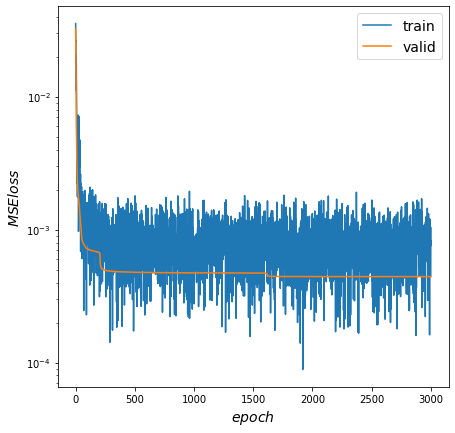

In [ ]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


### Variable 20

#### Train first

In [ ]:

torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3000
BATCH_SIZE = 16
LR = 0.0001
print(training_data.shape) 

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle=True)

(240, 200)


In [ ]:
# setup_seed(1)
t_train_0 = time.time()
autoencoder = CAE_1(10).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

t_train_1 = time.time()

Epoch:  0 | train loss: 0.010335 | valid loss: 0.007554
Epoch:  1 | train loss: 0.009042 | valid loss: 0.006770
Epoch:  2 | train loss: 0.010475 | valid loss: 0.006106
Epoch:  3 | train loss: 0.006965 | valid loss: 0.005559
Epoch:  4 | train loss: 0.004784 | valid loss: 0.005109
Epoch:  5 | train loss: 0.010302 | valid loss: 0.004747
Epoch:  6 | train loss: 0.005605 | valid loss: 0.004452
Epoch:  7 | train loss: 0.009534 | valid loss: 0.004209
Epoch:  8 | train loss: 0.007603 | valid loss: 0.004012
Epoch:  9 | train loss: 0.007527 | valid loss: 0.003844
Epoch:  10 | train loss: 0.009950 | valid loss: 0.003699
Epoch:  11 | train loss: 0.003227 | valid loss: 0.003573
Epoch:  12 | train loss: 0.005284 | valid loss: 0.003458
Epoch:  13 | train loss: 0.012031 | valid loss: 0.003352
Epoch:  14 | train loss: 0.002907 | valid loss: 0.003259
Epoch:  15 | train loss: 0.005572 | valid loss: 0.003170
Epoch:  16 | train loss: 0.004286 | valid loss: 0.003090
Epoch:  17 | train loss: 0.008737 | valid

In [ ]:
train_encoded1, train_decoded1 = autoencoder(torch.tensor(training_data).float().to(device))
train_error_autoencoder1 = (train_decoded1.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder1**2).mean())

valid_encoded1, valid_decoded1 = autoencoder(torch.tensor(valid_data).float().to(device))
valid_error_autoencoder1 = (valid_decoded1.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder1**2).mean())

test_encoded1, test_decoded1 = autoencoder(torch.tensor(test_data).float().to(device))
test_error_autoencoder1 = (test_decoded1.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder1**2).mean())

total_encoded1, total_decoded1 = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder1 = (total_decoded1.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder1**2).mean())

Train MSE:  0.00028356109359654365
valid MSE:  0.00014655063923186843
Test MSE:  0.00034413603535787173
Total MSE:  0.0002759175424626857


#### Train second

In [ ]:

torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3000
BATCH_SIZE = 16
LR = 0.0001
print(training_data.shape)

train_set = TensorDataset(torch.from_numpy(training_data), train_encoded1)
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size = BATCH_SIZE, shuffle=True)

(240, 200)


In [ ]:
# setup_seed(1)
t_train_2 = time.time()
autoencoder_2 = CAE_2(10).to(device)
optimizer = torch.optim.Adam(autoencoder_2.parameters(), lr=LR)
autoencoder_2.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for x, mode in train_loader:
        detach_mode = mode.detach()
        b_mode = detach_mode.to(device)  #b_mode = True  #The size is [16,128]
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder_2(b_x.float(),b_mode.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder_2(torch.tensor(valid_data).float().to(device),valid_encoded1.float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)
t_train_3 = time.time()

Epoch:  0 | train loss: 0.071758 | valid loss: 0.060058
Epoch:  1 | train loss: 0.064676 | valid loss: 0.044935
Epoch:  2 | train loss: 0.049848 | valid loss: 0.033895
Epoch:  3 | train loss: 0.034604 | valid loss: 0.025575
Epoch:  4 | train loss: 0.019523 | valid loss: 0.019613
Epoch:  5 | train loss: 0.013293 | valid loss: 0.015226
Epoch:  6 | train loss: 0.018679 | valid loss: 0.012091
Epoch:  7 | train loss: 0.013287 | valid loss: 0.009656
Epoch:  8 | train loss: 0.014723 | valid loss: 0.007870
Epoch:  9 | train loss: 0.010140 | valid loss: 0.006370
Epoch:  10 | train loss: 0.005954 | valid loss: 0.005193
Epoch:  11 | train loss: 0.004405 | valid loss: 0.004297
Epoch:  12 | train loss: 0.007758 | valid loss: 0.003618
Epoch:  13 | train loss: 0.010535 | valid loss: 0.003075
Epoch:  14 | train loss: 0.003296 | valid loss: 0.002638
Epoch:  15 | train loss: 0.002612 | valid loss: 0.002287
Epoch:  16 | train loss: 0.001149 | valid loss: 0.001996
Epoch:  17 | train loss: 0.005111 | valid

In [ ]:
t_pre_0 = time.time()
train_encoded2, train_decoded2 = autoencoder_2(torch.tensor(training_data).float().to(device),train_encoded1.float().to(device))
train_error_autoencoder2 = (train_decoded2.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder2**2).mean())

valid_encoded2, valid_decoded2 = autoencoder_2(torch.tensor(valid_data).float().to(device),valid_encoded1.float().to(device))
valid_error_autoencoder2 = (valid_decoded2.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder2**2).mean())

test_encoded2, test_decoded2 = autoencoder_2(torch.tensor(test_data).float().to(device),test_encoded1.float().to(device))
test_error_autoencoder2 = (test_decoded2.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder2**2).mean())
t_pre_1 = time.time()

total_encoded2, total_decoded2 = autoencoder_2(torch.tensor(total_data).float().to(device),total_encoded1.float().to(device))
total_error_autoencoder2 = (total_decoded2.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder2**2).mean())

print("Reconstruction time: ", t_pre_1- t_pre_0)

Train MSE:  0.00012233766378231872
valid MSE:  0.000144626143116499
Test MSE:  0.00021377473398369868
Total MSE:  0.000133710218779555
Reconstruction time:  0.010093212127685547


In [ ]:
total_decoded2 = total_decoded2.cpu().detach().numpy().transpose()
print(total_decoded2.shape)
os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
path = "./BE_results/results_csv/HAE_20.csv"
saveNumpy(path,total_decoded2)

(200, 300)


Text(0, 0.5, '$MSE loss$')

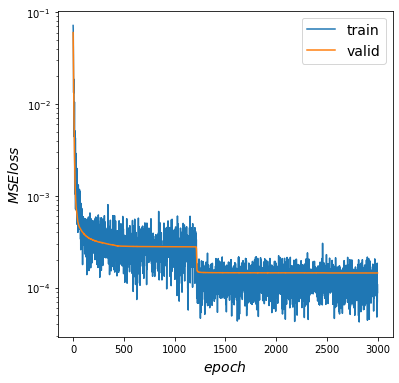

In [ ]:
fig = plt.figure(figsize=(6,6))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


# SVD

## load matrix

In [21]:
# Gnerate the burgers function data
S,x = S_Matrix()
S = np.array(S)
print(S.shape)

(200, 300)


## Generate the snapshots matrix

In [22]:
# The total data is divided into three parts
snaps = np.zeros([n,len(train_index)])
for i in range(len(train_index)):
    snaps[:,i]= S[:,int(train_index[i])]
print('train data shape',snaps.shape)

valid_data = np.zeros([n,len(valid_index)])
for i in range(len(valid_index)):
    valid_data[:,i] = S[:,int(valid_index[i])]
print('valid data shape',valid_data.shape)

test_data = np.zeros([n,len(test_index)])
for i in range(len(test_index)):
    test_data[:,i] = S[:,int(test_index[i])]
print('test data shape',test_data.shape)


total_data = np.zeros([n,len(train_index)+len(valid_index)+len(test_index)])
for i in range(len(train_index)+len(valid_index)+len(test_index)):
    total_data[:,i] = S[:,i]
print('total data shape',total_data.shape)

train data shape (200, 240)
valid data shape (200, 30)
test data shape (200, 30)
total data shape (200, 300)


## SVD of the snapshot matrix

In [23]:
# Using la.svd to do the singular value decomposition
t_train_0 = time.time()
u,sigma2,vt = la.svd(snaps)
t_train_1 = time.time()

print(u.shape)
print(sigma2.shape)
print(vt.shape)

(200, 200)
(200,)
(240, 240)


In [24]:
print('Train time: ',t_train_1-t_train_0)

Train time:  0.028420686721801758


## Calcualte the fraction of the information
The amount of information carried by each basis function
depends on the square of its singular value. Suppose that the fraction of information of the original system to be
captured is $\gamma$, where $0\leq\gamma\leq1$, then the lowest integer value of P is sought, such that the following is satisfied:
$$\frac{\sum_{i=1}^P\sigma_i^2}{\sum_{i=1}^M\sigma_i^2}\geqslant\gamma$$

In [26]:
# Calcualte the fraction of the information according to the above function
def calculate_gamma(P,sigma):
    M = len(sigma)
    sigma_sum = 0
    for i in range(M):
        sigma_sum += sigma[i]*sigma[i]
    P_sum = 0
    for i in range(P+1):
        P_sum += sigma[i]*sigma[i]
    res = P_sum / sigma_sum * 100  # 100 percent
    return res  

In [27]:
for i in range(10):
    print(calculate_gamma(i,sigma2))

83.49046668216971
94.1603817817246
97.3909179106289
98.62971861412736
99.20212329121267
99.52537405758093
99.69942524121005
99.81063926383106
99.87585913262589
99.91991938465011


## Calculate MSE and relative square error

MSE equation
$$\frac1N{\textstyle\sum_{p=1}^N}{\textstyle(}{\textstyle{\scriptstyle u}^{t_p}}{\textstyle-}{\textstyle R}{\textstyle{\scriptstyle R}^T}{\textstyle{\scriptstyle u}^{t_p}}{\textstyle)}{\textstyle\cdot}{\textstyle(u^{t_p}-RR^Tu^{t_p})}$$

The relative square error
$$\frac{\frac1N\sum_{p=1}^N(u^{t_p}-RR^Tu^{t_p})\cdot(u^{t_p}-RR^Tu^{t_p})}{\frac1N\sum_{p=1}^N(u^{t_p})\cdot(u^{t_p})}$$

In [28]:
# The function is used to calculate the mean square error accoridng to the above equation
def MSE(S,index,R,RT):
    k = np.zeros([n,len(index)])
    for i in range(len(index)):
        k[:,i] = S[:,int(index[i])] - R @ RT @ S[:,int(index[i])]
    return (k**2).mean()

# This function is used to calculate the relative square error according to the above equation
def relative_error(S,index,R,RT):
    k = np.zeros([n,len(index)])
    h = np.zeros([n,len(index)])
    for i in range(len(index)):
        k[:,i] = S[:,int(index[i])] - R @ RT @ S[:,int(index[i])]
        h[:,i] = S[:,int(index[i])]
    return (k**2).mean()/(h**2).mean()

1 variable

In [29]:
# Choose the number of basis function
R = u[:,0:1]
print(R.shape)
RT = R.transpose()
print(RT.shape)

(200, 1)
(1, 200)


In [30]:
print("The train MSE: ",MSE(total_data, train_index, R, RT))
print("The valid MSE: ",MSE(total_data, valid_index, R, RT))
print("The test MSE: ",MSE(total_data, test_index, R, RT))
print("The total MSE: ",MSE(total_data, total_index, R, RT))
print("The train relative square error: ",relative_error(total_data, train_index, R, RT))
print("The valid relative square error: ",relative_error(total_data, valid_index, R, RT))
print("The test relative square error: ",relative_error(total_data, test_index, R, RT))
print("The total relative square error: ",relative_error(total_data, total_index, R, RT))

The train MSE:  0.0010333939472137905
The valid MSE:  0.0006509491734556637
The test MSE:  0.0012612623253405386
The total MSE:  0.0010179363076506529
The train relative square error:  0.16509533317830327
The valid relative square error:  0.19304053590921727
The test relative square error:  0.16939101385346972
The total relative square error:  0.1671681286191167


In [33]:
t_rec_0 = time.time()
S_pre = R @ RT @ S
t_rec_1 = time.time()
print("reconstruction time: ",t_rec_1-t_rec_0)

reconstruction time:  0.0013623237609863281


2 variables

In [34]:
# Choose the number of basis function
R = u[:,0:2]
print(R.shape)
RT = R.transpose()
print(RT.shape)

(200, 2)
(2, 200)


In [35]:
print("The train MSE: ",MSE(total_data, train_index, R, RT))
print("The valid MSE: ",MSE(total_data, valid_index, R, RT))
print("The test MSE: ",MSE(total_data, test_index, R, RT))
print("The total MSE: ",MSE(total_data, total_index, R, RT))
print("The train relative square error: ",relative_error(total_data, train_index, R, RT))
print("The valid relative square error: ",relative_error(total_data, valid_index, R, RT))
print("The test relative square error: ",relative_error(total_data, test_index, R, RT))
print("The total relative square error: ",relative_error(total_data, total_index, R, RT))

The train MSE:  0.00036552372527016264
The valid MSE:  0.0002460237608154152
The test MSE:  0.00037048533831230074
The total MSE:  0.00035406989012890167
The train relative square error:  0.0583961821827543
The valid relative square error:  0.07295893530686474
The test relative square error:  0.049757204202244054
The total relative square error:  0.05814627151853


In [36]:
t_rec_0 = time.time()
S_pre = R @ RT @ S
t_rec_1 = time.time()
print("reconstruction time: ",t_rec_1-t_rec_0)

reconstruction time:  0.004471302032470703


In [ ]:
# os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
# path = "./BE_results/results_csv/SVD_2.csv"
# saveNumpy(path,S_pre)

In [ ]:
# t_rec_0 = time.time()
# S_pre = R @ RT @ S
# t_rec_1 = time.time()
S,x = S_Matrix()
print(S_pre.shape)
picPath = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/POD_BE/"
Save_pic(picPath,x,S_pre,'POD')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
videoPath = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/POD_BE_2variable"
picTovideo(picPath,videoPath,300,'POD')

4 variables

In [37]:
# Choose the number of basis function
R = u[:,0:4]
print(R.shape)
RT = R.transpose()
print(RT.shape)

(200, 4)
(4, 200)


In [38]:
print("The train MSE: ",MSE(total_data, train_index, R, RT))
print("The valid MSE: ",MSE(total_data, valid_index, R, RT))
print("The test MSE: ",MSE(total_data, test_index, R, RT))
print("The total MSE: ",MSE(total_data, total_index, R, RT))
print("The train relative square error: ",relative_error(total_data, train_index, R, RT))
print("The valid relative square error: ",relative_error(total_data, valid_index, R, RT))
print("The test relative square error: ",relative_error(total_data, test_index, R, RT))
print("The total relative square error: ",relative_error(total_data, total_index, R, RT))

The train MSE:  8.577107922312993e-05
The valid MSE:  7.120888367440013e-05
The test MSE:  0.0001216507452570015
The total MSE:  8.790282627164412e-05
The train relative square error:  0.01370281385872657
The valid relative square error:  0.021117164943968657
The test relative square error:  0.0163380310829073
The total relative square error:  0.014435629083784603


In [39]:
t_rec_0 = time.time()
S_pre = R @ RT @ S
t_rec_1 = time.time()
print("reconstruction time: ",t_rec_1-t_rec_0)

reconstruction time:  0.006340742111206055


6 variables

In [40]:
# Choose the number of basis function
R = u[:,0:6]
print(R.shape)
RT = R.transpose()
print(RT.shape)

(200, 6)
(6, 200)


In [41]:
print("The train MSE: ",MSE(total_data, train_index, R, RT))
print("The valid MSE: ",MSE(total_data, valid_index, R, RT))
print("The test MSE: ",MSE(total_data, test_index, R, RT))
print("The total MSE: ",MSE(total_data, total_index, R, RT))
print("The train relative square error: ",relative_error(total_data, train_index, R, RT))
print("The valid relative square error: ",relative_error(total_data, valid_index, R, RT))
print("The test relative square error: ",relative_error(total_data, test_index, R, RT))
print("The total relative square error: ",relative_error(total_data, total_index, R, RT))

The train MSE:  2.9708627533208588e-05
The valid MSE:  2.782581041666927e-05
The test MSE:  4.4327807273637414e-05
The total MSE:  3.098226379559754e-05
The train relative square error:  0.004746259424190802
The valid relative square error:  0.008251810700406353
The test relative square error:  0.005953346948625701
The total relative square error:  0.005087987352614723


In [42]:
t_rec_0 = time.time()
S_pre = R @ RT @ S
t_rec_1 = time.time()
print("reconstruction time: ",t_rec_1-t_rec_0)

reconstruction time:  0.00616002082824707


10 variables

In [43]:
# Choose the number of basis function
R = u[:,0:10]
print(R.shape)
RT = R.transpose()
print(RT.shape)

(200, 10)
(10, 200)


In [44]:
print("The train MSE: ",MSE(total_data, train_index, R, RT))
print("The valid MSE: ",MSE(total_data, valid_index, R, RT))
print("The test MSE: ",MSE(total_data, test_index, R, RT))
print("The total MSE: ",MSE(total_data, total_index, R, RT))
print("The train relative square error: ",relative_error(total_data, train_index, R, RT))
print("The valid relative square error: ",relative_error(total_data, valid_index, R, RT))
print("The test relative square error: ",relative_error(total_data, test_index, R, RT))
print("The total relative square error: ",relative_error(total_data, total_index, R, RT))

The train MSE:  5.012547695843476e-06
The valid MSE:  4.593639421743044e-06
The test MSE:  8.305175763186331e-06
The total MSE:  5.2999196751677195e-06
The train relative square error:  0.0008008061534989911
The valid relative square error:  0.0013622547687394543
The test relative square error:  0.001115408043586458
The total relative square error:  0.0008703664927467


In [45]:
t_rec_0 = time.time()
S_pre = R @ RT @ S
t_rec_1 = time.time()
print("reconstruction time: ",t_rec_1-t_rec_0)

reconstruction time:  0.0011742115020751953


20 variables

In [46]:
# Choose the number of basis function
R = u[:,0:20]
print(R.shape)
RT = R.transpose()
print(RT.shape)

(200, 20)
(20, 200)


In [47]:
print("The train MSE: ",MSE(total_data, train_index, R, RT))
print("The valid MSE: ",MSE(total_data, valid_index, R, RT))
print("The test MSE: ",MSE(total_data, test_index, R, RT))
print("The total MSE: ",MSE(total_data, total_index, R, RT))
print("The train relative square error: ",relative_error(total_data, train_index, R, RT))
print("The valid relative square error: ",relative_error(total_data, valid_index, R, RT))
print("The test relative square error: ",relative_error(total_data, test_index, R, RT))
print("The total relative square error: ",relative_error(total_data, total_index, R, RT))

The train MSE:  2.1221919642080544e-08
The valid MSE:  1.9919272639581915e-08
The test MSE:  3.7147773553563765e-08
The total MSE:  2.2684240332979e-08
The train relative square error:  3.3904203749585408e-06
The valid relative square error:  5.9071079925545075e-06
The test relative square error:  4.98904858903029e-06
The total relative square error:  3.725264515185953e-06


In [48]:
t_rec_0 = time.time()
S_pre = R @ RT @ S
t_rec_1 = time.time()
print("reconstruction time: ",t_rec_1-t_rec_0)

reconstruction time:  0.002229928970336914


In [ ]:
os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
path = "./BE_results/results_csv/SVD_20.csv"
saveNumpy(path,S_pre)

#### Sum

In [49]:
# the relation between the number of the basis and error
error_train = []
error_valid = []
error_test= []
error_total = []
for i in range(20):
    R = u[:,0:i+1]
    RT = R.transpose()
    error_train.append(MSE(total_data, train_index, R, RT))
    error_valid.append(MSE(total_data, valid_index, R, RT))
    error_test.append(MSE(total_data, test_index, R, RT))
    error_total.append(MSE(total_data, total_index, R, RT))

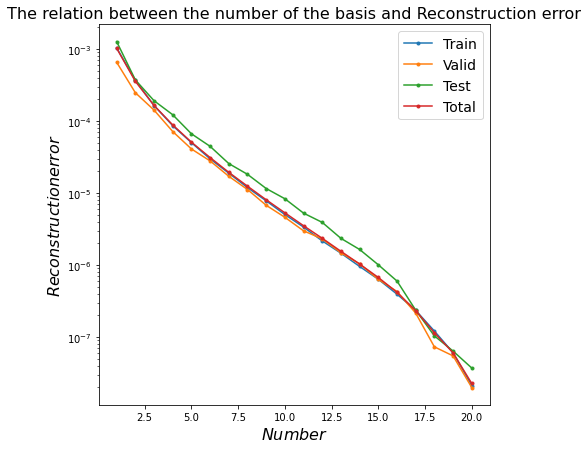

In [50]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$Number$', fontsize=16)
ax1.set_ylabel('$Reconstruction error$', fontsize=16)
ax1.set_title('The relation between the number of the basis and Reconstruction error', fontsize=16)
x=[i for i in range(1,21)]
ax1.semilogy(x,error_train, '.-',label="Train")
ax1.semilogy(x,error_valid, '.-',label="Valid")
ax1.semilogy(x,error_test, '.-',label="Test")
ax1.semilogy(x,error_total, '.-',label="Total")
ax1.legend(loc = "best",fontsize=14)

In [51]:
# the relation between the number of the basis and relative square error
error_train = []
error_valid = []
error_test= []
error_total = []
for i in range(20):
    R = u[:,0:i+1]
    RT = R.transpose()
    error_train.append(relative_error(total_data, train_index, R, RT))
    error_valid.append(relative_error(total_data, valid_index, R, RT))
    error_test.append(relative_error(total_data, test_index, R, RT))
    error_total.append(relative_error(total_data, total_index, R, RT))

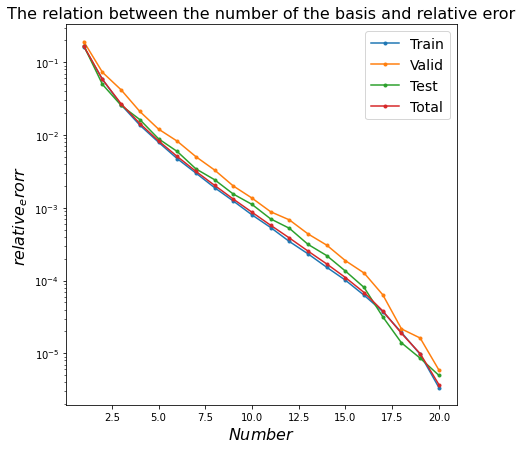

In [52]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$Number$', fontsize=16)
ax1.set_ylabel('$relative_erorr$', fontsize=16)
ax1.set_title('The relation between the number of the basis and relative eror', fontsize=16)
x=[i for i in range(1,21)]
ax1.semilogy(x,error_train, '.-',label="Train")
ax1.semilogy(x,error_valid, '.-',label="Valid")
ax1.semilogy(x,error_test, '.-',label="Test")
ax1.semilogy(x,error_total, '.-',label="Total")
ax1.legend(loc = "best",fontsize=14)

# FC autoecoder

## Load data

In [53]:
# Generate the data
S,x = S_Matrix()
S = np.array(S)
print(S.shape)

# Transpose the data, the first number means the number of the solutions
S = S.transpose()
print(S.shape)

# The total data is divided into three parts
training_data = np.zeros([len(train_index),n])
for i in range(len(train_index)):
    training_data[i,:]= S[int(train_index[i]),:]


valid_data = np.zeros([len(valid_index),n])
for i in range(len(valid_index)):
    valid_data[i,:] = S[int(valid_index[i]),:]


test_data = np.zeros([len(test_index),n])
for i in range(len(test_index)):
    test_data[i,:] = S[int(test_index[i]),:]


total_data = np.zeros([len(total_index),n])
for i in range(len(total_index)):
    total_data[i,:] = S[i,:]

print("training data shape:",training_data.shape)
print("valid data shape:",valid_data.shape)
print("test data:",test_data.shape)
print('total data shape',total_data.shape)

(200, 300)
(300, 200)
training data shape: (240, 200)
valid data shape: (30, 200)
test data: (30, 200)
total data shape (300, 200)


## Network structure

In [55]:
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 5000
BATCH_SIZE = 32
LR = 0.0001
print(training_data.shape)

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle= True)

(240, 200)


In [56]:
class FC(nn.Module):
    def __init__(self,hidden_1):
        super(FC, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(200, hidden_1),
            nn.ReLU(),
            # nn.Sigmoid(),
           
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_1, 200),
            nn.ReLU(),
            # nn.Sigmoid(),
        )


    def forward(self,x):
        encoded = self.fc1(x)
        decoded = self.fc2(encoded)
        return encoded, decoded



def weight_init(m):
    classname = m.__class__.__name__
    if classname.find("Linear")!=-1:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias, 0.05)


## Train

Run 10 times and choose the best value to record it

1 varaible 

In [58]:
t_train_0 = time.time()
autoencoder = FC(1).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weight_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

t_train_1 = time.time()

Epoch:  0 | train loss: 0.004276 | valid loss: 0.004453
Epoch:  1 | train loss: 0.009247 | valid loss: 0.004363
Epoch:  2 | train loss: 0.004496 | valid loss: 0.004276
Epoch:  3 | train loss: 0.007737 | valid loss: 0.004192
Epoch:  4 | train loss: 0.007072 | valid loss: 0.004110
Epoch:  5 | train loss: 0.005284 | valid loss: 0.004032
Epoch:  6 | train loss: 0.005673 | valid loss: 0.003957
Epoch:  7 | train loss: 0.004735 | valid loss: 0.003884
Epoch:  8 | train loss: 0.007584 | valid loss: 0.003813
Epoch:  9 | train loss: 0.005334 | valid loss: 0.003744
Epoch:  10 | train loss: 0.005045 | valid loss: 0.003677
Epoch:  11 | train loss: 0.005133 | valid loss: 0.003612
Epoch:  12 | train loss: 0.008566 | valid loss: 0.003550
Epoch:  13 | train loss: 0.008084 | valid loss: 0.003489
Epoch:  14 | train loss: 0.003607 | valid loss: 0.003429
Epoch:  15 | train loss: 0.008834 | valid loss: 0.003372
Epoch:  16 | train loss: 0.006196 | valid loss: 0.003316
Epoch:  17 | train loss: 0.006824 | valid

In [59]:
print('Train time: ',t_train_1-t_train_0)

Train time:  63.93136739730835


In [60]:
t_pre_0 = time.time()
train_encoded, train_decoded = autoencoder(torch.tensor(training_data).float().to(device))
valid_encoded, valid_decoded = autoencoder(torch.tensor(valid_data).float().to(device))
test_encoded, test_decoded = autoencoder(torch.tensor(test_data).float().to(device))
t_pre_1 = time.time()

train_error_autoencoder = (train_decoded.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder**2).mean())
valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder**2).mean())
test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder**2).mean())


total_encoded, total_decoded = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder = (total_decoded.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder**2).mean())
print('Reconstruction time: ',t_pre_1-t_pre_0)

Train MSE:  0.0007275558300546676
valid MSE:  0.0004428883000850995
Test MSE:  0.0008182643165664477
Total MSE:  0.000708159925708889
Reconstruction time:  0.0018906593322753906


Text(0, 0.5, '$MSE loss$')

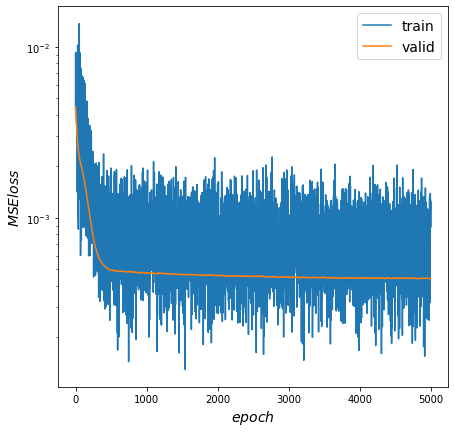

In [61]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


2 varaibles

In [64]:
t_train_0 = time.time()
autoencoder = FC(2).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weight_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

t_train_1 = time.time()

Epoch:  0 | train loss: 0.006036 | valid loss: 0.004311
Epoch:  1 | train loss: 0.003742 | valid loss: 0.004227
Epoch:  2 | train loss: 0.007586 | valid loss: 0.004145
Epoch:  3 | train loss: 0.005957 | valid loss: 0.004068
Epoch:  4 | train loss: 0.009763 | valid loss: 0.003993
Epoch:  5 | train loss: 0.005326 | valid loss: 0.003921
Epoch:  6 | train loss: 0.010369 | valid loss: 0.003852
Epoch:  7 | train loss: 0.006813 | valid loss: 0.003786
Epoch:  8 | train loss: 0.007819 | valid loss: 0.003723
Epoch:  9 | train loss: 0.007355 | valid loss: 0.003662
Epoch:  10 | train loss: 0.003643 | valid loss: 0.003603
Epoch:  11 | train loss: 0.007593 | valid loss: 0.003546
Epoch:  12 | train loss: 0.007782 | valid loss: 0.003492
Epoch:  13 | train loss: 0.011343 | valid loss: 0.003438
Epoch:  14 | train loss: 0.008024 | valid loss: 0.003387
Epoch:  15 | train loss: 0.002708 | valid loss: 0.003337
Epoch:  16 | train loss: 0.003869 | valid loss: 0.003288
Epoch:  17 | train loss: 0.002762 | valid

In [65]:
print('Train time: ',t_train_1-t_train_0)

Train time:  65.2139573097229


In [66]:
t_pre_0 = time.time()
train_encoded, train_decoded = autoencoder(torch.tensor(training_data).float().to(device))
valid_encoded, valid_decoded = autoencoder(torch.tensor(valid_data).float().to(device))
test_encoded, test_decoded = autoencoder(torch.tensor(test_data).float().to(device))
t_pre_1 = time.time()

train_error_autoencoder = (train_decoded.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder**2).mean())
valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder**2).mean())
test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder**2).mean())


total_encoded, total_decoded = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder = (total_decoded.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder**2).mean())
print('Reconstruction time: ',t_pre_1-t_pre_0)

Train MSE:  7.239745717296477e-05
valid MSE:  4.538798370925176e-05
Test MSE:  8.568432935329078e-05
Total MSE:  7.102519704462606e-05
Reconstruction time:  0.006178379058837891


Text(0, 0.5, '$MSE loss$')

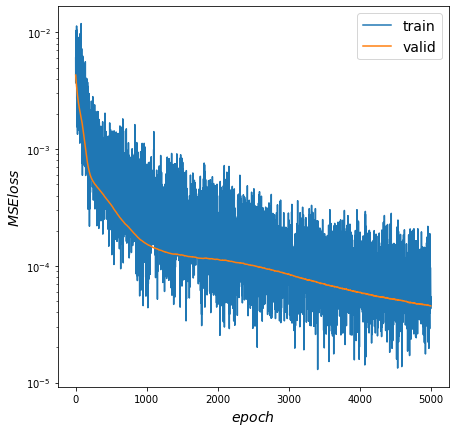

In [67]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


In [68]:
S,x = S_Matrix()
total_decoded = total_decoded.cpu().detach().numpy().transpose()
print(total_decoded.shape)
picPath = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/FCAE_BE/"
Save_pic(picPath,x,total_decoded,'FCAE')
videoPath = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/FCAE_BE_2variable"
picTovideo(picPath,videoPath,300,'FCAE')

Output hidden; open in https://colab.research.google.com to view.

4 varaibles

In [69]:
t_train_0 = time.time()
autoencoder = FC(4).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weight_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

t_train_1 = time.time()

Epoch:  0 | train loss: 0.008356 | valid loss: 0.004561
Epoch:  1 | train loss: 0.006069 | valid loss: 0.004457
Epoch:  2 | train loss: 0.003890 | valid loss: 0.004357
Epoch:  3 | train loss: 0.006857 | valid loss: 0.004261
Epoch:  4 | train loss: 0.009638 | valid loss: 0.004169
Epoch:  5 | train loss: 0.007317 | valid loss: 0.004080
Epoch:  6 | train loss: 0.002515 | valid loss: 0.003994
Epoch:  7 | train loss: 0.008288 | valid loss: 0.003912
Epoch:  8 | train loss: 0.004121 | valid loss: 0.003832
Epoch:  9 | train loss: 0.010876 | valid loss: 0.003752
Epoch:  10 | train loss: 0.004319 | valid loss: 0.003675
Epoch:  11 | train loss: 0.003475 | valid loss: 0.003601
Epoch:  12 | train loss: 0.005672 | valid loss: 0.003530
Epoch:  13 | train loss: 0.007957 | valid loss: 0.003461
Epoch:  14 | train loss: 0.005019 | valid loss: 0.003395
Epoch:  15 | train loss: 0.005894 | valid loss: 0.003331
Epoch:  16 | train loss: 0.002210 | valid loss: 0.003269
Epoch:  17 | train loss: 0.003566 | valid

In [70]:
print('Train time: ',t_train_1-t_train_0)

Train time:  64.81717944145203


In [71]:
t_pre_0 = time.time()
train_encoded, train_decoded = autoencoder(torch.tensor(training_data).float().to(device))
valid_encoded, valid_decoded = autoencoder(torch.tensor(valid_data).float().to(device))
test_encoded, test_decoded = autoencoder(torch.tensor(test_data).float().to(device))
t_pre_1 = time.time()

train_error_autoencoder = (train_decoded.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder**2).mean())
valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder**2).mean())
test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder**2).mean())


total_encoded, total_decoded = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder = (total_decoded.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder**2).mean())
print('Reconstruction time: ',t_pre_1-t_pre_0)

Train MSE:  1.8312962870172893e-05
valid MSE:  1.1543990713575513e-05
Test MSE:  2.2579136282745622e-05
Total MSE:  1.806268299577043e-05
Reconstruction time:  0.003737926483154297


Text(0, 0.5, '$MSE loss$')

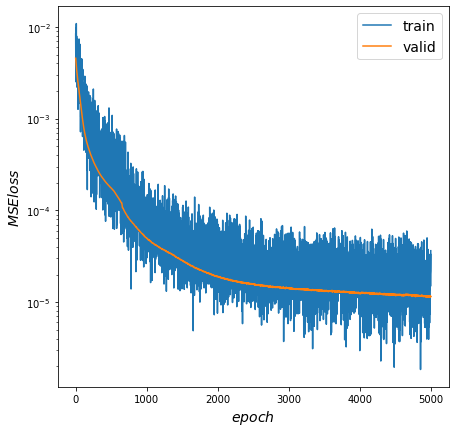

In [72]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


6 varaibles

In [73]:
t_train_0 = time.time()
autoencoder = FC(6).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weight_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

t_train_1 = time.time()

Epoch:  0 | train loss: 0.006578 | valid loss: 0.004432
Epoch:  1 | train loss: 0.004490 | valid loss: 0.004320
Epoch:  2 | train loss: 0.006776 | valid loss: 0.004212
Epoch:  3 | train loss: 0.006662 | valid loss: 0.004110
Epoch:  4 | train loss: 0.006361 | valid loss: 0.004012
Epoch:  5 | train loss: 0.006015 | valid loss: 0.003918
Epoch:  6 | train loss: 0.005815 | valid loss: 0.003828
Epoch:  7 | train loss: 0.007733 | valid loss: 0.003743
Epoch:  8 | train loss: 0.006164 | valid loss: 0.003660
Epoch:  9 | train loss: 0.005368 | valid loss: 0.003580
Epoch:  10 | train loss: 0.003451 | valid loss: 0.003504
Epoch:  11 | train loss: 0.009720 | valid loss: 0.003430
Epoch:  12 | train loss: 0.003785 | valid loss: 0.003359
Epoch:  13 | train loss: 0.004230 | valid loss: 0.003290
Epoch:  14 | train loss: 0.004533 | valid loss: 0.003223
Epoch:  15 | train loss: 0.005274 | valid loss: 0.003159
Epoch:  16 | train loss: 0.002329 | valid loss: 0.003095
Epoch:  17 | train loss: 0.004442 | valid

In [74]:
print('Train time: ',t_train_1-t_train_0)

Train time:  65.31381011009216


In [75]:
t_pre_0 = time.time()
train_encoded, train_decoded = autoencoder(torch.tensor(training_data).float().to(device))
valid_encoded, valid_decoded = autoencoder(torch.tensor(valid_data).float().to(device))
test_encoded, test_decoded = autoencoder(torch.tensor(test_data).float().to(device))
t_pre_1 = time.time()

train_error_autoencoder = (train_decoded.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder**2).mean())
valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder**2).mean())
test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder**2).mean())


total_encoded, total_decoded = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder = (total_decoded.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder**2).mean())
print('Reconstruction time: ',t_pre_1-t_pre_0)

Train MSE:  1.1691397371252406e-05
valid MSE:  6.7799353225081115e-06
Test MSE:  1.4322453838340489e-05
Total MSE:  1.1463356813086783e-05
Reconstruction time:  0.0021238327026367188


Text(0, 0.5, '$MSE loss$')

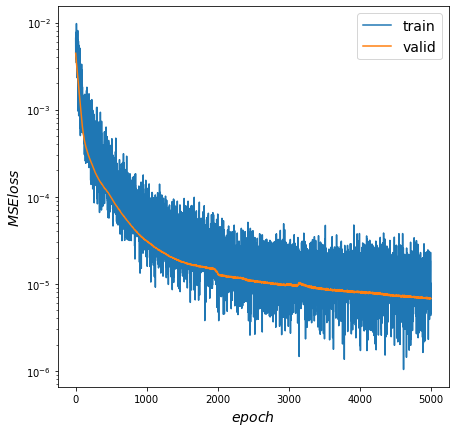

In [76]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


10 varaibles

In [77]:
t_train_0 = time.time()
autoencoder = FC(10).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weight_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

t_train_1 = time.time()

Epoch:  0 | train loss: 0.005452 | valid loss: 0.004899
Epoch:  1 | train loss: 0.007109 | valid loss: 0.004740
Epoch:  2 | train loss: 0.010114 | valid loss: 0.004588
Epoch:  3 | train loss: 0.006693 | valid loss: 0.004445
Epoch:  4 | train loss: 0.005516 | valid loss: 0.004308
Epoch:  5 | train loss: 0.005642 | valid loss: 0.004179
Epoch:  6 | train loss: 0.004407 | valid loss: 0.004058
Epoch:  7 | train loss: 0.007305 | valid loss: 0.003940
Epoch:  8 | train loss: 0.006103 | valid loss: 0.003826
Epoch:  9 | train loss: 0.007859 | valid loss: 0.003717
Epoch:  10 | train loss: 0.004708 | valid loss: 0.003609
Epoch:  11 | train loss: 0.003963 | valid loss: 0.003505
Epoch:  12 | train loss: 0.005553 | valid loss: 0.003406
Epoch:  13 | train loss: 0.004683 | valid loss: 0.003310
Epoch:  14 | train loss: 0.006896 | valid loss: 0.003217
Epoch:  15 | train loss: 0.004438 | valid loss: 0.003129
Epoch:  16 | train loss: 0.005901 | valid loss: 0.003047
Epoch:  17 | train loss: 0.006171 | valid

In [78]:
print('Train time: ',t_train_1-t_train_0)

Train time:  64.73628616333008


In [79]:
t_pre_0 = time.time()
train_encoded, train_decoded = autoencoder(torch.tensor(training_data).float().to(device))
valid_encoded, valid_decoded = autoencoder(torch.tensor(valid_data).float().to(device))
test_encoded, test_decoded = autoencoder(torch.tensor(test_data).float().to(device))
t_pre_1 = time.time()

train_error_autoencoder = (train_decoded.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder**2).mean())
valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder**2).mean())
test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder**2).mean())


total_encoded, total_decoded = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder = (total_decoded.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder**2).mean())
print('Reconstruction time: ',t_pre_1-t_pre_0)

Train MSE:  6.339042757778725e-06
valid MSE:  3.7061217075965903e-06
Test MSE:  7.352321123109969e-06
Total MSE:  6.177078489293637e-06
Reconstruction time:  0.004511356353759766


Text(0, 0.5, '$MSE loss$')

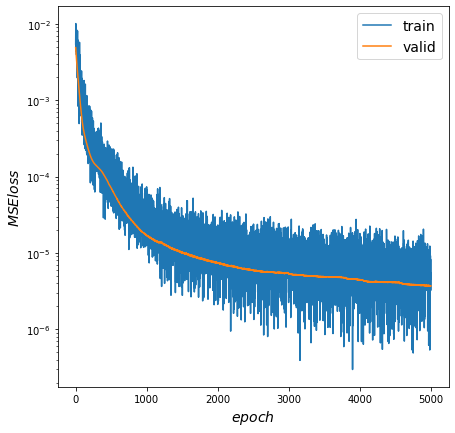

In [80]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


20 variables

In [89]:
t_train_0 = time.time()
autoencoder = FC(20).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weight_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

t_train_1 = time.time()

Epoch:  0 | train loss: 0.007961 | valid loss: 0.005563
Epoch:  1 | train loss: 0.017939 | valid loss: 0.005324
Epoch:  2 | train loss: 0.008197 | valid loss: 0.005105
Epoch:  3 | train loss: 0.006182 | valid loss: 0.004904
Epoch:  4 | train loss: 0.008329 | valid loss: 0.004718
Epoch:  5 | train loss: 0.003155 | valid loss: 0.004547
Epoch:  6 | train loss: 0.008731 | valid loss: 0.004390
Epoch:  7 | train loss: 0.005372 | valid loss: 0.004241
Epoch:  8 | train loss: 0.006935 | valid loss: 0.004101
Epoch:  9 | train loss: 0.006914 | valid loss: 0.003968
Epoch:  10 | train loss: 0.002952 | valid loss: 0.003842
Epoch:  11 | train loss: 0.016512 | valid loss: 0.003723
Epoch:  12 | train loss: 0.002178 | valid loss: 0.003609
Epoch:  13 | train loss: 0.004251 | valid loss: 0.003500
Epoch:  14 | train loss: 0.003229 | valid loss: 0.003394
Epoch:  15 | train loss: 0.010130 | valid loss: 0.003294
Epoch:  16 | train loss: 0.006409 | valid loss: 0.003196
Epoch:  17 | train loss: 0.001953 | valid

In [90]:
print('Train time: ',t_train_1-t_train_0)

Train time:  66.15512752532959


In [91]:
t_pre_0 = time.time()
train_encoded, train_decoded = autoencoder(torch.tensor(training_data).float().to(device))
valid_encoded, valid_decoded = autoencoder(torch.tensor(valid_data).float().to(device))
test_encoded, test_decoded = autoencoder(torch.tensor(test_data).float().to(device))
t_pre_1 = time.time()

train_error_autoencoder = (train_decoded.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder**2).mean())
valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder**2).mean())
test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder**2).mean())


total_encoded, total_decoded = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder = (total_decoded.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder**2).mean())
print('Reconstruction time: ',t_pre_1-t_pre_0)

Train MSE:  4.838958938698238e-06
valid MSE:  3.079050606671766e-06
Test MSE:  6.395470832933919e-06
Total MSE:  4.818619294919158e-06
Reconstruction time:  0.004999399185180664


Text(0, 0.5, '$MSE loss$')

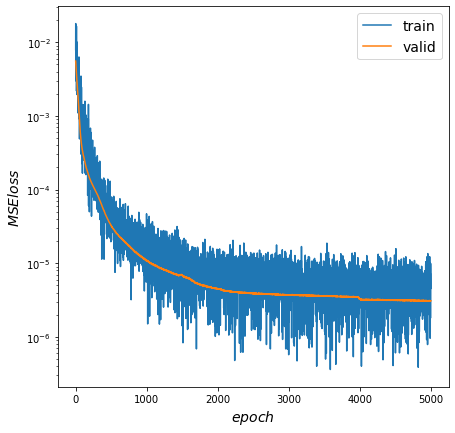

In [92]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


In [ ]:
total_decoded = total_decoded.cpu().detach().numpy().transpose()
print(total_decoded.shape)
os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
path = "./BE_results/results_csv/AE_20.csv"
saveNumpy(path,total_decoded)

(200, 300)


# Convolution autoencoder

## Load the data

In [95]:
# Generate the burger equation data
S,x = S_Matrix()
print(S.shape)

S = S.transpose()
print(S.shape)

# The total data is divided into three parts
training_data = np.zeros([len(train_index),n])
for i in range(len(train_index)):
    training_data[i,:]= S[int(train_index[i]),:]


valid_data = np.zeros([len(valid_index),n])
for i in range(len(valid_index)):
    valid_data[i,:] = S[int(valid_index[i]),:]


test_data = np.zeros([len(test_index),n])
for i in range(len(test_index)):
    test_data[i,:] = S[int(test_index[i]),:]

total_data = np.zeros([len(total_index),n])
for i in range(len(total_index)):
    total_data[i,:] = S[i,:]

print("training data shape:",training_data.shape)
print("valid data shape:",valid_data.shape)
print("test data shape:",test_data.shape)
print("total data shape:" ,total_data.shape)

(200, 300)
(300, 200)
training data shape: (240, 200)
valid data shape: (30, 200)
test data shape: (30, 200)
total data shape: (300, 200)


## Network structure

In [96]:
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3000
BATCH_SIZE = 16
LR = 0.0001
print(training_data.shape) 

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle=True)

(240, 200)


In [98]:
class CAE(nn.Module):
    def __init__(self,hidden_1):
        super(CAE,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1,8,3,3,15), # (b,8,76)
            nn.ReLU(),    
            nn.Conv1d(8,16,3,3,15), # (b,16,35)
            nn.ReLU(),
            nn.Conv1d(16,16,3,3,15), # (b,16,21)
            nn.ReLU(),
        )
        self.fc1=nn.Sequential(
            nn.Linear(16*21,hidden_1),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_1,16*21),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(16,16,3,3,14), #(b,16,35)
            nn.ReLU(),
            nn.ConvTranspose1d(16,8,4,3,15), #(b,8,76)
            nn.ReLU(),
            nn.ConvTranspose1d(8,1,3,3,14), #(b,1,200)
            nn.ReLU(),
        )

    def forward(self,x):
        encoded_1 = self.encoder(x.view(-1,1,200))
        encoded = self.fc1(encoded_1.view(-1,16*21))
        decoded_1 = self.fc2(encoded)
        decoded = self.decoder(decoded_1.view(-1,16,21)).view(-1,200)
        
        return encoded,decoded

def weights_init(m):
    classname = m.__class__.__name__
    # kaiming initialization to Conv1d layer
    if classname.find('Conv1d') != -1:
        nn.init.constant_(m.bias.data, 0)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif classname.find('Linear') != -1:
    # xavier initialization to Linear layer
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias.data, 0.05)
    elif classname.find('ConvTranspose1d') != -1:
    # kaiming initialization to ConvTranspose1d layer
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0.05)

## Train

Run 10 times and choose the best value to record it

In [93]:
# autoencoder = CAE(1).to(device)
# autoencoder.apply(weights_init)
# print(autoencoder)

In [ ]:
# for name, parameters in autoencoder.named_parameters():

#     print(name, ':', parameters)

encoder.0.weight : Parameter containing:
tensor([[[0., 0., 0.]],

        [[0., 0., 0.]],

        [[0., 0., 0.]],

        [[0., 0., 0.]],

        [[0., 0., 0.]],

        [[0., 0., 0.]],

        [[0., 0., 0.]],

        [[0., 0., 0.]]], device='cuda:0', requires_grad=True)
encoder.0.bias : Parameter containing:
tensor([0.8182, 0.8182, 0.8182, 0.8182, 0.8182, 0.8182, 0.8182, 0.8182],
       device='cuda:0', requires_grad=True)
encoder.2.weight : Parameter containing:
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0

1 variable

In [105]:
t_train_0 = time.time()
autoencoder = CAE(1).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)
t_train_1 = time.time()

Epoch:  0 | train loss: 0.007999 | valid loss: 0.006623
Epoch:  1 | train loss: 0.008372 | valid loss: 0.006083
Epoch:  2 | train loss: 0.004995 | valid loss: 0.005634
Epoch:  3 | train loss: 0.008257 | valid loss: 0.005247
Epoch:  4 | train loss: 0.008325 | valid loss: 0.004910
Epoch:  5 | train loss: 0.003898 | valid loss: 0.004629
Epoch:  6 | train loss: 0.005016 | valid loss: 0.004393
Epoch:  7 | train loss: 0.003257 | valid loss: 0.004190
Epoch:  8 | train loss: 0.003783 | valid loss: 0.004011
Epoch:  9 | train loss: 0.007953 | valid loss: 0.003860
Epoch:  10 | train loss: 0.005616 | valid loss: 0.003730
Epoch:  11 | train loss: 0.003268 | valid loss: 0.003623
Epoch:  12 | train loss: 0.006861 | valid loss: 0.003528
Epoch:  13 | train loss: 0.003586 | valid loss: 0.003447
Epoch:  14 | train loss: 0.005853 | valid loss: 0.003376
Epoch:  15 | train loss: 0.005171 | valid loss: 0.003315
Epoch:  16 | train loss: 0.005357 | valid loss: 0.003259
Epoch:  17 | train loss: 0.009144 | valid

In [107]:
print("Train time: ", t_train_1-t_train_0)

Train time:  174.92871975898743


In [106]:
t_pre_0 = time.time()
train_encoded, train_decoded = autoencoder(torch.tensor(training_data).float().to(device))
valid_encoded, valid_decoded = autoencoder(torch.tensor(valid_data).float().to(device))
test_encoded, test_decoded = autoencoder(torch.tensor(test_data).float().to(device))
t_pre_1 = time.time()

train_error_autoencoder = (train_decoded.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder**2).mean())
valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder**2).mean())
test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder**2).mean())

total_encoded, total_decoded = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder = (total_decoded.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder**2).mean())
print('Recstruction time: ',t_pre_1-t_pre_0)

Train MSE:  7.981731365338597e-06
valid MSE:  4.723362981785786e-06
Test MSE:  9.615061651593094e-06
Total MSE:  7.819227555608765e-06
Recstruction time:  0.008142232894897461


Text(0, 0.5, '$MSE loss$')

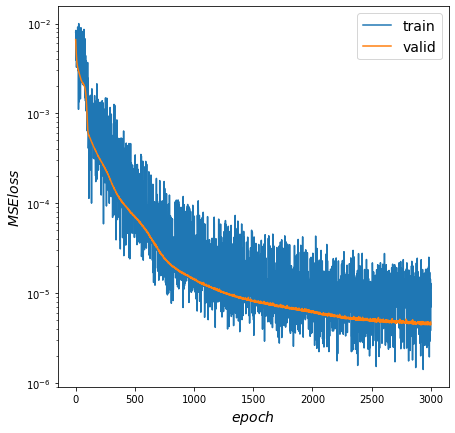

In [108]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


2 variables

In [ ]:
# setup_seed(2)
autoencoder = CAE(2).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

Epoch:  0 | train loss: 0.008083 | valid loss: 0.005250
Epoch:  1 | train loss: 0.007219 | valid loss: 0.004893
Epoch:  2 | train loss: 0.004566 | valid loss: 0.004586
Epoch:  3 | train loss: 0.006714 | valid loss: 0.004318
Epoch:  4 | train loss: 0.004945 | valid loss: 0.004093
Epoch:  5 | train loss: 0.003073 | valid loss: 0.003914
Epoch:  6 | train loss: 0.006389 | valid loss: 0.003765
Epoch:  7 | train loss: 0.006835 | valid loss: 0.003640
Epoch:  8 | train loss: 0.011224 | valid loss: 0.003539
Epoch:  9 | train loss: 0.002998 | valid loss: 0.003453
Epoch:  10 | train loss: 0.004688 | valid loss: 0.003381
Epoch:  11 | train loss: 0.001268 | valid loss: 0.003318
Epoch:  12 | train loss: 0.007512 | valid loss: 0.003260
Epoch:  13 | train loss: 0.004100 | valid loss: 0.003210
Epoch:  14 | train loss: 0.010615 | valid loss: 0.003160
Epoch:  15 | train loss: 0.008476 | valid loss: 0.003116
Epoch:  16 | train loss: 0.008020 | valid loss: 0.003075
Epoch:  17 | train loss: 0.003968 | valid

Text(0, 0.5, '$MSE loss$')

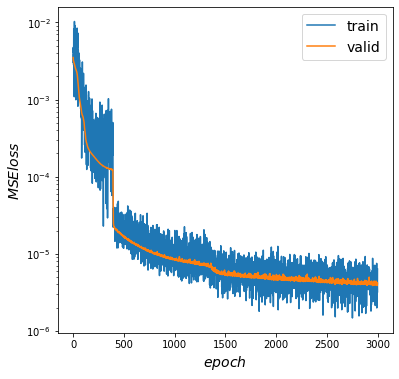

In [ ]:
fig = plt.figure(figsize=(6,6))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


In [ ]:
train_encoded, train_decoded = autoencoder(torch.tensor(training_data).float().to(device))
train_error_autoencoder = (train_decoded.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder**2).mean())

valid_encoded, valid_decoded = autoencoder(torch.tensor(valid_data).float().to(device))
valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder**2).mean())

test_encoded, test_decoded = autoencoder(torch.tensor(test_data).float().to(device))
test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder**2).mean())

total_encoded, total_decoded = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder = (total_decoded.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder**2).mean())

Train MSE:  4.297437328651501e-06
valid MSE:  3.6118975356035005e-06
Test MSE:  5.379276851423497e-06
Total MSE:  4.3370673016239e-06


In [ ]:
# Save total_decoded as csv file
# total_decoded = total_decoded.cpu().detach().numpy().transpose()
# print(total_decoded.shape)
# os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
# path = "./BE_results/results_csv/CAE_2.csv"
# saveNumpy(path,total_decoded)

(200, 300)


In [ ]:
# Save the pictures of total_decoded and using these pictures to generate video
S,x = S_Matrix()
total_decoded = total_decoded.cpu().detach().numpy().transpose()
print(total_decoded.shape)
picPath = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/CAE_BE/"
Save_pic(picPath,x,total_decoded,'CAE')
videoPath = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/CAE_BE_2variable"
picTovideo(picPath,videoPath,300,'CAE')

Output hidden; open in https://colab.research.google.com to view.

4 variables

In [ ]:
# setup_seed(1)
autoencoder = CAE(4).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

Epoch:  0 | train loss: 0.008263 | valid loss: 0.004241
Epoch:  1 | train loss: 0.002237 | valid loss: 0.003935
Epoch:  2 | train loss: 0.004494 | valid loss: 0.003693
Epoch:  3 | train loss: 0.010699 | valid loss: 0.003510
Epoch:  4 | train loss: 0.002781 | valid loss: 0.003368
Epoch:  5 | train loss: 0.003625 | valid loss: 0.003256
Epoch:  6 | train loss: 0.003333 | valid loss: 0.003168
Epoch:  7 | train loss: 0.006836 | valid loss: 0.003096
Epoch:  8 | train loss: 0.005011 | valid loss: 0.003034
Epoch:  9 | train loss: 0.004150 | valid loss: 0.002984
Epoch:  10 | train loss: 0.000771 | valid loss: 0.002938
Epoch:  11 | train loss: 0.008752 | valid loss: 0.002893
Epoch:  12 | train loss: 0.003035 | valid loss: 0.002853
Epoch:  13 | train loss: 0.005251 | valid loss: 0.002811
Epoch:  14 | train loss: 0.004488 | valid loss: 0.002769
Epoch:  15 | train loss: 0.007156 | valid loss: 0.002729
Epoch:  16 | train loss: 0.008125 | valid loss: 0.002690
Epoch:  17 | train loss: 0.009133 | valid

In [ ]:
train_encoded, train_decoded = autoencoder(torch.tensor(training_data).float().to(device))
train_error_autoencoder = (train_decoded.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder**2).mean())

valid_encoded, valid_decoded = autoencoder(torch.tensor(valid_data).float().to(device))
valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder**2).mean())

test_encoded, test_decoded = autoencoder(torch.tensor(test_data).float().to(device))
test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder**2).mean())

total_encoded, total_decoded = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder = (total_decoded.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder**2).mean())

Train MSE:  8.422714644813546e-06
valid MSE:  5.162022413704481e-06
Test MSE:  1.0887101436274339e-05
Total MSE:  8.34308283885469e-06


Text(0, 0.5, '$MSE loss$')

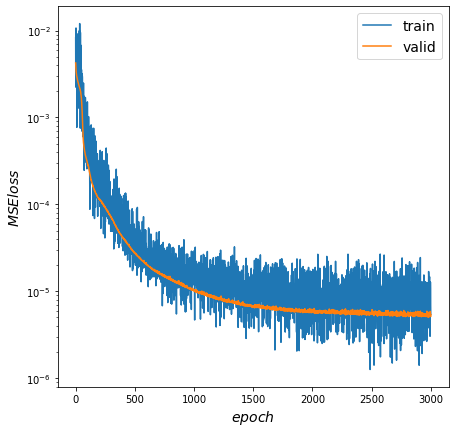

In [ ]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


6 variables

In [ ]:
# setup_seed(1)
t_train_0 = time.time()
autoencoder = CAE(6).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)
t_train_1 = time.time()

Epoch:  0 | train loss: 0.012917 | valid loss: 0.004000
Epoch:  1 | train loss: 0.013425 | valid loss: 0.003712
Epoch:  2 | train loss: 0.002734 | valid loss: 0.003512
Epoch:  3 | train loss: 0.002049 | valid loss: 0.003370
Epoch:  4 | train loss: 0.004293 | valid loss: 0.003266
Epoch:  5 | train loss: 0.001634 | valid loss: 0.003190
Epoch:  6 | train loss: 0.004897 | valid loss: 0.003132
Epoch:  7 | train loss: 0.002956 | valid loss: 0.003085
Epoch:  8 | train loss: 0.007018 | valid loss: 0.003046
Epoch:  9 | train loss: 0.006582 | valid loss: 0.003008
Epoch:  10 | train loss: 0.001145 | valid loss: 0.002972
Epoch:  11 | train loss: 0.001945 | valid loss: 0.002937
Epoch:  12 | train loss: 0.003782 | valid loss: 0.002904
Epoch:  13 | train loss: 0.008856 | valid loss: 0.002868
Epoch:  14 | train loss: 0.004048 | valid loss: 0.002828
Epoch:  15 | train loss: 0.006758 | valid loss: 0.002788
Epoch:  16 | train loss: 0.011213 | valid loss: 0.002750
Epoch:  17 | train loss: 0.004271 | valid

In [ ]:
print('Train time: ',t_train_1-t_train_0)

Train time:  170.75733065605164


In [ ]:
train_encoded, train_decoded = autoencoder(torch.tensor(training_data).float().to(device))
train_error_autoencoder = (train_decoded.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder**2).mean())

valid_encoded, valid_decoded = autoencoder(torch.tensor(valid_data).float().to(device))
valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder**2).mean())

test_encoded, test_decoded = autoencoder(torch.tensor(test_data).float().to(device))
test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder**2).mean())

total_encoded, total_decoded = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder = (total_decoded.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder**2).mean())

Train MSE:  8.288498637091118e-06
valid MSE:  4.654829395168055e-06
Test MSE:  1.06298946832332e-05
Total MSE:  8.159271317513022e-06


Text(0, 0.5, '$MSE loss$')

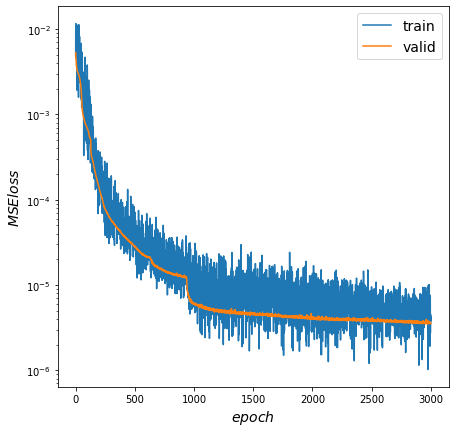

In [ ]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


10 variables

In [ ]:
# setup_seed(1)
autoencoder = CAE(10).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

Epoch:  0 | train loss: 0.002815 | valid loss: 0.004064
Epoch:  1 | train loss: 0.013441 | valid loss: 0.003704
Epoch:  2 | train loss: 0.002544 | valid loss: 0.003447
Epoch:  3 | train loss: 0.001700 | valid loss: 0.003261
Epoch:  4 | train loss: 0.003869 | valid loss: 0.003117
Epoch:  5 | train loss: 0.006882 | valid loss: 0.002996
Epoch:  6 | train loss: 0.008880 | valid loss: 0.002891
Epoch:  7 | train loss: 0.001432 | valid loss: 0.002801
Epoch:  8 | train loss: 0.004753 | valid loss: 0.002718
Epoch:  9 | train loss: 0.002153 | valid loss: 0.002646
Epoch:  10 | train loss: 0.004895 | valid loss: 0.002583
Epoch:  11 | train loss: 0.004428 | valid loss: 0.002527
Epoch:  12 | train loss: 0.007978 | valid loss: 0.002474
Epoch:  13 | train loss: 0.002071 | valid loss: 0.002425
Epoch:  14 | train loss: 0.003387 | valid loss: 0.002376
Epoch:  15 | train loss: 0.008523 | valid loss: 0.002334
Epoch:  16 | train loss: 0.009145 | valid loss: 0.002296
Epoch:  17 | train loss: 0.005316 | valid

In [ ]:
train_encoded, train_decoded = autoencoder(torch.tensor(training_data).float().to(device))
train_error_autoencoder = (train_decoded.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder**2).mean())

valid_encoded, valid_decoded = autoencoder(torch.tensor(valid_data).float().to(device))
valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder**2).mean())

test_encoded, test_decoded = autoencoder(torch.tensor(test_data).float().to(device))
test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder**2).mean())

total_encoded, total_decoded = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder = (total_decoded.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder**2).mean())

Train MSE:  5.49231667283255e-06
valid MSE:  5.038900728856811e-06
Test MSE:  6.6986748370113e-06
Total MSE:  5.567609959791975e-06


Text(0, 0.5, '$MSE loss$')

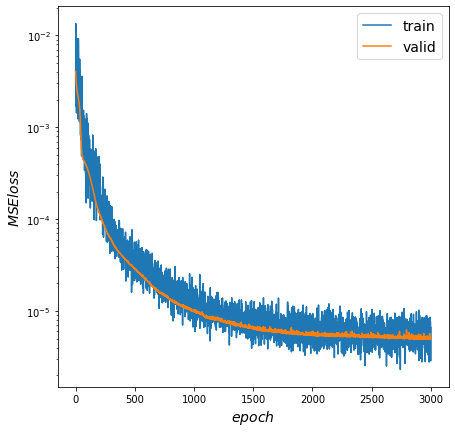

In [ ]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)

20 variables

In [ ]:
# setup_seed(1)
autoencoder = CAE(20).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weights_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(valid_data).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(valid_data).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

Epoch:  0 | train loss: 0.005988 | valid loss: 0.005885
Epoch:  1 | train loss: 0.005672 | valid loss: 0.005283
Epoch:  2 | train loss: 0.008065 | valid loss: 0.004794
Epoch:  3 | train loss: 0.007606 | valid loss: 0.004411
Epoch:  4 | train loss: 0.005024 | valid loss: 0.004109
Epoch:  5 | train loss: 0.008335 | valid loss: 0.003865
Epoch:  6 | train loss: 0.006617 | valid loss: 0.003670
Epoch:  7 | train loss: 0.006812 | valid loss: 0.003502
Epoch:  8 | train loss: 0.010482 | valid loss: 0.003364
Epoch:  9 | train loss: 0.007110 | valid loss: 0.003251
Epoch:  10 | train loss: 0.004074 | valid loss: 0.003154
Epoch:  11 | train loss: 0.005718 | valid loss: 0.003065
Epoch:  12 | train loss: 0.013639 | valid loss: 0.002982
Epoch:  13 | train loss: 0.001828 | valid loss: 0.002906
Epoch:  14 | train loss: 0.002860 | valid loss: 0.002834
Epoch:  15 | train loss: 0.003711 | valid loss: 0.002765
Epoch:  16 | train loss: 0.004464 | valid loss: 0.002697
Epoch:  17 | train loss: 0.005804 | valid

In [ ]:
train_encoded, train_decoded = autoencoder(torch.tensor(training_data).float().to(device))
train_error_autoencoder = (train_decoded.cpu().detach().numpy() - training_data)
print('Train MSE: ', (train_error_autoencoder**2).mean())

valid_encoded, valid_decoded = autoencoder(torch.tensor(valid_data).float().to(device))
valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data)
print('valid MSE: ', (valid_error_autoencoder**2).mean())

test_encoded, test_decoded = autoencoder(torch.tensor(test_data).float().to(device))
test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data)
print('Test MSE: ', (test_error_autoencoder**2).mean())

t_train_0 = time.time()
total_encoded, total_decoded = autoencoder(torch.tensor(total_data).float().to(device))
total_error_autoencoder = (total_decoded.cpu().detach().numpy() - total_data)
print('Total MSE: ', (total_error_autoencoder**2).mean())
t_train_1 = time.time()

Train MSE:  3.7849387430485502e-06
valid MSE:  2.8283752915488487e-06
Test MSE:  6.067581292405812e-06
Total MSE:  3.917546652834306e-06


Text(0, 0.5, '$MSE loss$')

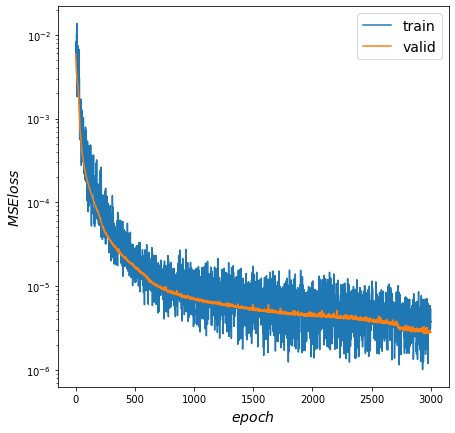

In [ ]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


In [ ]:
# Save the total_decoded as the csv file
# total_decoded = total_decoded.cpu().detach().numpy().transpose()
# print(total_decoded.shape)
# os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
# path = "./BE_results/results_csv/CAE_20.csv"
# saveNumpy(path,total_decoded)

(200, 300)


# SVD autoencoder

## SVD

In [131]:
# This function is used to calculate the MSE of SVD_AE
def SVD_MSE(S,decoded,R):
    decoded1 = decoded.transpose()
    k = np.zeros([n,S.shape[1]])
    for i in range(S.shape[1]):
        k[:,i] = S[:,i] - R @ decoded1[:,i]
    return (k**2).mean()

### Load matrix

In [132]:
# Generate the burgers equation data
S,x = S_Matrix()
print(S.shape)

(200, 300)


In [133]:
# The total data is divided into three parts
training_data = np.zeros([n,len(train_index)])
for i in range(len(train_index)):
    training_data[:,i]= S[:,int(train_index[i])]
print('train data shape',training_data.shape)

valid_data = np.zeros([n,len(valid_index)])
for i in range(len(valid_index)):
    valid_data[:,i] = S[:,int(valid_index[i])]
print('valid data shape',valid_data.shape)

test_data = np.zeros([n,len(test_index)])
for i in range(len(test_index)):
    test_data[:,i] = S[:,int(test_index[i])]
print('test data shape',test_data.shape)

total_data = np.zeros([n,len(train_index)+len(valid_index)+len(test_index)])
for i in range(len(train_index)+len(valid_index)+len(test_index)):
    total_data[:,i] = S[:,i]
print('total data shape',total_data.shape)

train data shape (200, 240)
valid data shape (200, 30)
test data shape (200, 30)
total data shape (200, 300)


### Generate the snapshots matrix

In [134]:
print(len(train_index))
print(n)
print(S.shape)

240
200
(200, 300)


In [135]:
snaps = np.zeros([n,len(train_index)])
for i in range(len(train_index)):
    snaps[:,i]= S[:,int(train_index[i])]
print(snaps.shape)

(200, 240)


### SVD of the snapshot matrix

In [137]:
# using la.svd to do the singular value decomposition
t_train_0 = time.time()
u,sigma2,vt = la.svd(snaps)
t_train_1 = time.time()

print(u.shape)
print(sigma2.shape)
print(vt.shape)

(200, 200)
(200,)
(240, 240)


### Apply SVD to input

In [138]:
# Choose the number of the basis function. This problem we use SVD to reduce the variables from 
# 200 to 150
R = u[:,0:150]
print(R.shape)
RT = R.transpose()
print(RT.shape)

(200, 150)
(150, 200)


In [139]:
print(training_data.shape)
print(S.shape)

(200, 240)
(200, 300)


In [140]:
# Use SVD to reduce the variables of the data
S_train = np.zeros([RT.shape[0],len(train_index)])
S_valid = np.zeros([RT.shape[0],len(valid_index)])
S_test = np.zeros([RT.shape[0],len(test_index)])
S_total = np.zeros([RT.shape[0], S.shape[1]])

for i in range(len(train_index)):
    S_train[:,i] = RT@S[:,int(train_index[i])]

for i in range(len(valid_index)):
    S_valid[:,i] = RT@S[:,int(valid_index[i])]

for i in range(len(test_index)):
    S_test[:,i] = RT@S[:,int(test_index[i])]

for i in range(S.shape[1]):
    S_total[:,i] = RT@S[:,i]


print(S_train.shape)
print(S_valid.shape)
print(S_test.shape)
print(S_total.shape)

# For autoencoder, the solution must be arranged in row vetcor
S_train = S_train.transpose()
S_valid = S_valid.transpose()
S_test = S_test.transpose()
S_total = S_total.transpose()

print('S_train',S_train.shape)
print('S_valid',S_valid.shape)
print('S_test',S_test.shape)
print('S_total',S_total.shape)

(150, 240)
(150, 30)
(150, 30)
(150, 300)
S_train (240, 150)
S_valid (30, 150)
S_test (30, 150)
S_total (300, 150)


In [141]:
# normalisation, the data is transform to the range(0,1)
ma = np.max(S_total)
mi = np.min(S_total)
k = 1/(ma-mi)
b = 1-k*ma
S_train = k*S_train + b
S_valid = k*S_valid + b
S_test = k*S_test + b
S_total = k*S_total +b

## autoencooder

### Network structure

In [142]:
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 30000
BATCH_SIZE = 32
LR = 0.0001
print(training_data.shape) 

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = S_train, batch_size = BATCH_SIZE, shuffle= True)

(200, 240)


In [143]:
class SVD_FC(nn.Module):
    def __init__(self,hidden_1):
        super(SVD_FC, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(150, hidden_1),
            nn.Sigmoid(),   
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_1, 150),
            nn.Sigmoid(),
        )


    def forward(self,x):
        encoded = self.fc1(x)
        decoded = self.fc2(encoded)
        return encoded, decoded



def weight_init(m):
    classname = m.__class__.__name__
    if classname.find("Linear")!=-1:
        # For the Linear layer, use the xavier initialization
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias, 0.33)

### Train

Run 10 times and choose the best value to record it

1 variable

In [121]:
t_train_2 = time.time()
autoencoder = SVD_FC(1).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weight_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(S_valid).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(S_valid).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

t_train_3 = time.time()


流式输出内容被截断，只能显示最后 5000 行内容。
Epoch:  25000 | train loss: 0.000119 | valid loss: 0.000046
Epoch:  25001 | train loss: 0.000069 | valid loss: 0.000046
Epoch:  25002 | train loss: 0.000046 | valid loss: 0.000046
Epoch:  25003 | train loss: 0.000075 | valid loss: 0.000046
Epoch:  25004 | train loss: 0.000061 | valid loss: 0.000046
Epoch:  25005 | train loss: 0.000049 | valid loss: 0.000046
Epoch:  25006 | train loss: 0.000056 | valid loss: 0.000046
Epoch:  25007 | train loss: 0.000121 | valid loss: 0.000046
Epoch:  25008 | train loss: 0.000028 | valid loss: 0.000046
Epoch:  25009 | train loss: 0.000043 | valid loss: 0.000046
Epoch:  25010 | train loss: 0.000082 | valid loss: 0.000046
Epoch:  25011 | train loss: 0.000034 | valid loss: 0.000046
Epoch:  25012 | train loss: 0.000072 | valid loss: 0.000046
Epoch:  25013 | train loss: 0.000147 | valid loss: 0.000046
Epoch:  25014 | train loss: 0.000163 | valid loss: 0.000046
Epoch:  25015 | train loss: 0.000071 | valid loss: 0.000046
Epoch:  25016

In [122]:
print('Train time: ',t_train_1-t_train_0+t_train_3-t_train_2)

Train time:  387.3956525325775


In [123]:
# Before multipley R, the data range must be recovered
encoded_train, decoded_train = autoencoder(torch.tensor(S_train).float().to(device))
decoded_train_res = (decoded_train.cpu().detach().numpy() - b)/k

print("train MSE: ",SVD_MSE(training_data,decoded_train_res,R))

encoded_valid, decoded_valid = autoencoder(torch.tensor(S_valid).float().to(device))
decoded_valid_res = (decoded_valid.cpu().detach().numpy()-b)/k
print("valid MSE: ",SVD_MSE(valid_data,decoded_valid_res,R))

encoded, decoded_test = autoencoder(torch.tensor(S_test).float().to(device))
decoded_test_res = (decoded_test.cpu().detach().numpy()-b)/k
print("test MSE: ",SVD_MSE(test_data,decoded_test_res,R))

t_pre_0 = time.time()
encoded, decoded_total = autoencoder(torch.tensor(S_total).float().to(device))
# result = R @ decoded_total.cpu().detach().numpy().transpose()
decoded_total_res = (decoded_total.cpu().detach().numpy()-b)/k
t_pre_1 = time.time()
print("total MSE: ",SVD_MSE(total_data,decoded_total_res,R))
print("Reconstruction time:", t_pre_1-t_pre_0)


train MSE:  0.0006851669994546145
valid MSE:  0.0004933753000493329
test MSE:  0.0007889494561985727
total MSE:  0.0006763660827616986
Reconstruction time: 0.0017902851104736328


Text(0, 0.5, '$MSE loss$')

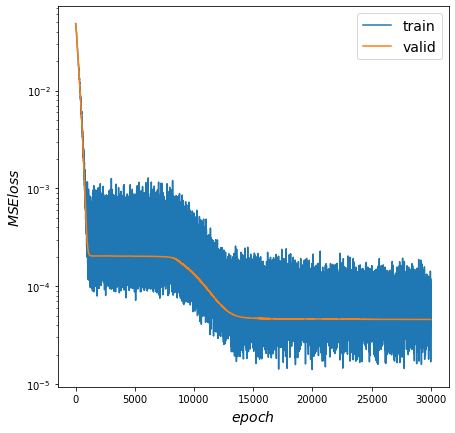

In [124]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


2 variables

In [144]:
t_train_2 = time.time()
autoencoder = SVD_FC(2).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weight_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(S_valid).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(S_valid).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)
t_train_3 = time.time()

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch:  25000 | train loss: 0.000017 | valid loss: 0.000019
Epoch:  25001 | train loss: 0.000035 | valid loss: 0.000019
Epoch:  25002 | train loss: 0.000026 | valid loss: 0.000019
Epoch:  25003 | train loss: 0.000064 | valid loss: 0.000019
Epoch:  25004 | train loss: 0.000032 | valid loss: 0.000019
Epoch:  25005 | train loss: 0.000020 | valid loss: 0.000019
Epoch:  25006 | train loss: 0.000023 | valid loss: 0.000019
Epoch:  25007 | train loss: 0.000050 | valid loss: 0.000019
Epoch:  25008 | train loss: 0.000069 | valid loss: 0.000019
Epoch:  25009 | train loss: 0.000047 | valid loss: 0.000019
Epoch:  25010 | train loss: 0.000038 | valid loss: 0.000019
Epoch:  25011 | train loss: 0.000052 | valid loss: 0.000019
Epoch:  25012 | train loss: 0.000046 | valid loss: 0.000019
Epoch:  25013 | train loss: 0.000050 | valid loss: 0.000019
Epoch:  25014 | train loss: 0.000019 | valid loss: 0.000019
Epoch:  25015 | train loss: 0.000018 | valid loss: 0.000019
Epoch:  25016

In [145]:
print('Train time: ',t_train_1-t_train_0+t_train_3-t_train_2)

Train time:  390.5707561969757


In [146]:
# Before multipley R, the data range must be recovered
encoded_train, decoded_train = autoencoder(torch.tensor(S_train).float().to(device))
decoded_train_res = (decoded_train.cpu().detach().numpy() - b)/k

print("train MSE: ",SVD_MSE(training_data,decoded_train_res,R))

encoded_valid, decoded_valid = autoencoder(torch.tensor(S_valid).float().to(device))
decoded_valid_res = (decoded_valid.cpu().detach().numpy()-b)/k
print("valid MSE: ",SVD_MSE(valid_data,decoded_valid_res,R))

encoded, decoded_test = autoencoder(torch.tensor(S_test).float().to(device))
decoded_test_res = (decoded_test.cpu().detach().numpy()-b)/k
print("test MSE: ",SVD_MSE(test_data,decoded_test_res,R))

t_pre_0 = time.time()
encoded, decoded_total = autoencoder(torch.tensor(S_total).float().to(device))
decoded_total_res = (decoded_total.cpu().detach().numpy()-b)/k
result = R @ decoded_total_res.transpose() # This is used to record the reconstruction time
t_pre_1 = time.time()
print("total MSE: ",SVD_MSE(total_data,decoded_total_res,R))
print("Reconstruction time:", t_pre_1-t_pre_0)


train MSE:  0.0002994989387515678
valid MSE:  0.0001887302342287179
test MSE:  0.0003079074794042794
total MSE:  0.000289262922364554
Reconstruction time: 0.0019025802612304688


Text(0, 0.5, '$MSE loss$')

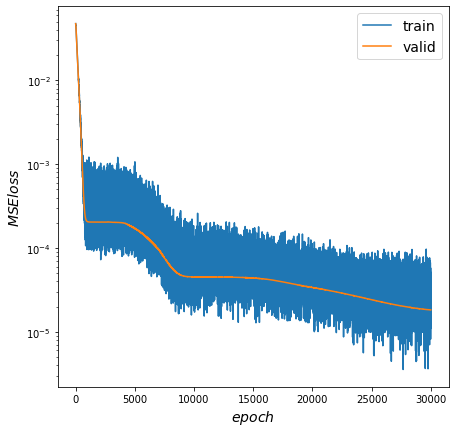

In [ ]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


In [147]:
# Save the data of the decoded_total as csv file
print(decoded_total.shape)
total_pre = R @ (decoded_total_res.transpose())
print(total_pre.shape)

os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
path = "./BE_results/results_csv/SVD_AE_2.csv"
saveNumpy(path,total_pre)

torch.Size([300, 150])
(200, 300)


In [148]:
# Save the pictures of data at each time step
S,x = S_Matrix()
print(x.shape)
print(total_pre.shape)
picPath = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/SVDAE_BE/"
Save_pic(picPath,x,total_pre,'SVDAE')

Output hidden; open in https://colab.research.google.com to view.

In [149]:
# Generate and save the video
videoPath = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/SVDAE_BE_2variable"
picTovideo(picPath,videoPath,300,'SVDAE')

(288, 432, 3)


4 variables

In [ ]:
autoencoder = SVD_FC(4).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weight_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(S_valid).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(S_valid).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch:  25000 | train loss: 0.000034 | valid loss: 0.000016
Epoch:  25001 | train loss: 0.000023 | valid loss: 0.000016
Epoch:  25002 | train loss: 0.000016 | valid loss: 0.000016
Epoch:  25003 | train loss: 0.000014 | valid loss: 0.000016
Epoch:  25004 | train loss: 0.000028 | valid loss: 0.000016
Epoch:  25005 | train loss: 0.000022 | valid loss: 0.000016
Epoch:  25006 | train loss: 0.000026 | valid loss: 0.000016
Epoch:  25007 | train loss: 0.000018 | valid loss: 0.000016
Epoch:  25008 | train loss: 0.000020 | valid loss: 0.000016
Epoch:  25009 | train loss: 0.000027 | valid loss: 0.000016
Epoch:  25010 | train loss: 0.000027 | valid loss: 0.000016
Epoch:  25011 | train loss: 0.000008 | valid loss: 0.000016
Epoch:  25012 | train loss: 0.000016 | valid loss: 0.000016
Epoch:  25013 | train loss: 0.000025 | valid loss: 0.000016
Epoch:  25014 | train loss: 0.000023 | valid loss: 0.000016
Epoch:  25015 | train loss: 0.000015 | valid loss: 0.000016
Epoch:  25016

In [ ]:
# Before multipley R, the data range must be recovered
encoded_train, decoded_train = autoencoder(torch.tensor(S_train).float().to(device))
decoded_train_res = (decoded_train.cpu().detach().numpy() - b)/k

print("train MSE: ",SVD_MSE(training_data,decoded_train_res,R))

encoded_valid, decoded_valid = autoencoder(torch.tensor(S_valid).float().to(device))
decoded_valid_res = (decoded_valid.cpu().detach().numpy()-b)/k
print("valid MSE: ",SVD_MSE(valid_data,decoded_valid_res,R))

encoded, decoded_test = autoencoder(torch.tensor(S_test).float().to(device))
decoded_test_res = (decoded_test.cpu().detach().numpy()-b)/k
print("test MSE: ",SVD_MSE(test_data,decoded_test_res,R))

t_pre_0 = time.time()
encoded, decoded_total = autoencoder(torch.tensor(S_total).float().to(device))
# result = R @ decoded_total.cpu().detach().numpy().transpose()
decoded_total_res = (decoded_total.cpu().detach().numpy()-b)/k
t_pre_1 = time.time()
print("total MSE: ",SVD_MSE(total_data,decoded_total_res,R))
print("Reconstruction time:", t_pre_1-t_pre_0)


train MSE:  0.00021902934191174843
valid MSE:  0.00014052299988242777
test MSE:  0.00022393352875781628
total MSE:  0.00021166912639342315
Reconstruction time: 0.0010361671447753906


Text(0, 0.5, '$MSE loss$')

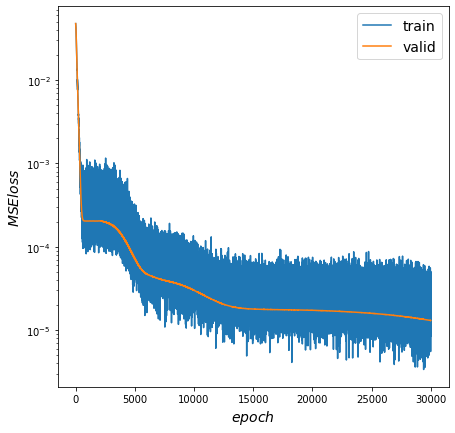

In [ ]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


6 variables

In [ ]:
autoencoder = SVD_FC(6).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weight_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(S_valid).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(S_valid).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch:  25000 | train loss: 0.000016 | valid loss: 0.000007
Epoch:  25001 | train loss: 0.000010 | valid loss: 0.000007
Epoch:  25002 | train loss: 0.000010 | valid loss: 0.000007
Epoch:  25003 | train loss: 0.000007 | valid loss: 0.000007
Epoch:  25004 | train loss: 0.000010 | valid loss: 0.000007
Epoch:  25005 | train loss: 0.000025 | valid loss: 0.000007
Epoch:  25006 | train loss: 0.000011 | valid loss: 0.000007
Epoch:  25007 | train loss: 0.000010 | valid loss: 0.000007
Epoch:  25008 | train loss: 0.000010 | valid loss: 0.000007
Epoch:  25009 | train loss: 0.000006 | valid loss: 0.000007
Epoch:  25010 | train loss: 0.000012 | valid loss: 0.000007
Epoch:  25011 | train loss: 0.000011 | valid loss: 0.000007
Epoch:  25012 | train loss: 0.000010 | valid loss: 0.000007
Epoch:  25013 | train loss: 0.000012 | valid loss: 0.000007
Epoch:  25014 | train loss: 0.000014 | valid loss: 0.000007
Epoch:  25015 | train loss: 0.000007 | valid loss: 0.000007
Epoch:  25016

In [ ]:
# Before multipley R, the data range must be recovered
encoded_train, decoded_train = autoencoder(torch.tensor(S_train).float().to(device))
decoded_train_res = (decoded_train.cpu().detach().numpy() - b)/k

print("train MSE: ",SVD_MSE(training_data,decoded_train_res,R))

encoded_valid, decoded_valid = autoencoder(torch.tensor(S_valid).float().to(device))
decoded_valid_res = (decoded_valid.cpu().detach().numpy()-b)/k
print("valid MSE: ",SVD_MSE(valid_data,decoded_valid_res,R))

encoded, decoded_test = autoencoder(torch.tensor(S_test).float().to(device))
decoded_test_res = (decoded_test.cpu().detach().numpy()-b)/k
print("test MSE: ",SVD_MSE(test_data,decoded_test_res,R))

t_pre_0 = time.time()
encoded, decoded_total = autoencoder(torch.tensor(S_total).float().to(device))
# result = R @ decoded_total.cpu().detach().numpy().transpose()
decoded_total_res = (decoded_total.cpu().detach().numpy()-b)/k
t_pre_1 = time.time()
print("total MSE: ",SVD_MSE(total_data,decoded_total_res,R))
print("Reconstruction time:", t_pre_1-t_pre_0)


train MSE:  8.411973355495285e-05
valid MSE:  6.159327352063894e-05
test MSE:  0.00010720177364455898
total MSE:  8.41752915604821e-05
Reconstruction time: 0.0009133815765380859


Text(0, 0.5, '$MSE loss$')

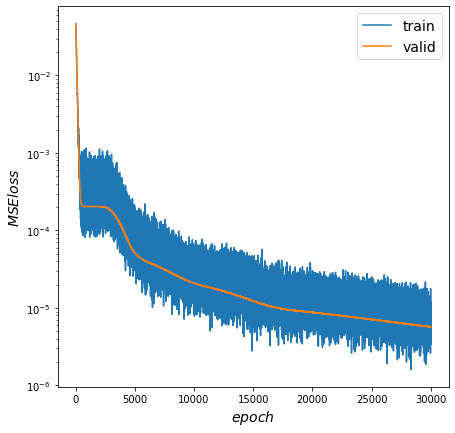

In [ ]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


10 variables

In [ ]:
autoencoder = SVD_FC(10).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weight_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(S_valid).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(S_valid).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch:  25000 | train loss: 0.000004 | valid loss: 0.000005
Epoch:  25001 | train loss: 0.000006 | valid loss: 0.000005
Epoch:  25002 | train loss: 0.000006 | valid loss: 0.000005
Epoch:  25003 | train loss: 0.000005 | valid loss: 0.000005
Epoch:  25004 | train loss: 0.000003 | valid loss: 0.000005
Epoch:  25005 | train loss: 0.000005 | valid loss: 0.000005
Epoch:  25006 | train loss: 0.000007 | valid loss: 0.000005
Epoch:  25007 | train loss: 0.000004 | valid loss: 0.000005
Epoch:  25008 | train loss: 0.000005 | valid loss: 0.000005
Epoch:  25009 | train loss: 0.000007 | valid loss: 0.000005
Epoch:  25010 | train loss: 0.000005 | valid loss: 0.000005
Epoch:  25011 | train loss: 0.000005 | valid loss: 0.000005
Epoch:  25012 | train loss: 0.000004 | valid loss: 0.000005
Epoch:  25013 | train loss: 0.000007 | valid loss: 0.000005
Epoch:  25014 | train loss: 0.000006 | valid loss: 0.000005
Epoch:  25015 | train loss: 0.000006 | valid loss: 0.000005
Epoch:  25016

In [ ]:
# Before multipley R, the data range must be recovered
encoded_train, decoded_train = autoencoder(torch.tensor(S_train).float().to(device))
decoded_train_res = (decoded_train.cpu().detach().numpy() - b)/k

print("train MSE: ",SVD_MSE(training_data,decoded_train_res,R))

encoded_valid, decoded_valid = autoencoder(torch.tensor(S_valid).float().to(device))
decoded_valid_res = (decoded_valid.cpu().detach().numpy()-b)/k
print("valid MSE: ",SVD_MSE(valid_data,decoded_valid_res,R))

encoded, decoded_test = autoencoder(torch.tensor(S_test).float().to(device))
decoded_test_res = (decoded_test.cpu().detach().numpy()-b)/k
print("test MSE: ",SVD_MSE(test_data,decoded_test_res,R))

t_pre_0 = time.time()
encoded, decoded_total = autoencoder(torch.tensor(S_total).float().to(device))
# result = R @ decoded_total.cpu().detach().numpy().transpose()
decoded_total_res = (decoded_total.cpu().detach().numpy()-b)/k
t_pre_1 = time.time()
print("total MSE: ",SVD_MSE(total_data,decoded_total_res,R))
print("Reconstruction time:", t_pre_1-t_pre_0)


train MSE:  5.0373239425743554e-05
valid MSE:  4.7259773335713185e-05
test MSE:  7.861844537248332e-05
total MSE:  5.28864134114145e-05
Reconstruction time: 0.0020627975463867188


Text(0, 0.5, '$MSE loss$')

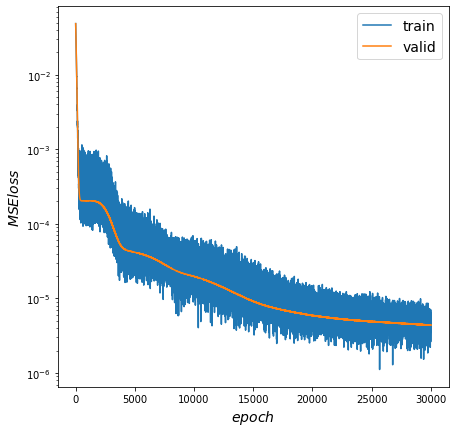

In [ ]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


20 variables

In [ ]:
t_train_2 = time.time()
autoencoder = SVD_FC(20).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
autoencoder.apply(weight_init)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
epoch_list=[]

for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        #print("x", x.shape)
        b_x = x.to(device)    # bx: False   x: False
        encoded, decoded = autoencoder(b_x.float())   #decoded true  by:False
   
        loss = loss_func(decoded, b_x.float())  #Loss: True  # mean square error
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                     # apply gradients

    loss_list.append(loss)
    encoded, decoded = autoencoder(torch.tensor(S_valid).float().to(device))
    error_autoencoder = (decoded.detach() - torch.tensor(S_valid).float().to(device))
    MSE_valid = (error_autoencoder**2).mean()
    loss_valid.append(MSE_valid)
    epoch_list.append(epoch)
    print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)
t_train_3 = time.time()

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch:  25000 | train loss: 0.000006 | valid loss: 0.000004
Epoch:  25001 | train loss: 0.000004 | valid loss: 0.000004
Epoch:  25002 | train loss: 0.000005 | valid loss: 0.000004
Epoch:  25003 | train loss: 0.000005 | valid loss: 0.000004
Epoch:  25004 | train loss: 0.000005 | valid loss: 0.000004
Epoch:  25005 | train loss: 0.000007 | valid loss: 0.000004
Epoch:  25006 | train loss: 0.000005 | valid loss: 0.000004
Epoch:  25007 | train loss: 0.000005 | valid loss: 0.000004
Epoch:  25008 | train loss: 0.000003 | valid loss: 0.000004
Epoch:  25009 | train loss: 0.000002 | valid loss: 0.000004
Epoch:  25010 | train loss: 0.000004 | valid loss: 0.000004
Epoch:  25011 | train loss: 0.000004 | valid loss: 0.000004
Epoch:  25012 | train loss: 0.000007 | valid loss: 0.000004
Epoch:  25013 | train loss: 0.000003 | valid loss: 0.000004
Epoch:  25014 | train loss: 0.000002 | valid loss: 0.000004
Epoch:  25015 | train loss: 0.000005 | valid loss: 0.000004
Epoch:  25016

In [ ]:
print('Train time: ',t_train_1-t_train_0+t_train_3-t_train_2)

In [ ]:
# Before multipley R, the data range must be recovered
encoded_train, decoded_train = autoencoder(torch.tensor(S_train).float().to(device))
decoded_train_res = (decoded_train.cpu().detach().numpy() - b)/k

print("train MSE: ",SVD_MSE(training_data,decoded_train_res,R))

encoded_valid, decoded_valid = autoencoder(torch.tensor(S_valid).float().to(device))
decoded_valid_res = (decoded_valid.cpu().detach().numpy()-b)/k
print("valid MSE: ",SVD_MSE(valid_data,decoded_valid_res,R))

encoded, decoded_test = autoencoder(torch.tensor(S_test).float().to(device))
decoded_test_res = (decoded_test.cpu().detach().numpy()-b)/k
print("test MSE: ",SVD_MSE(test_data,decoded_test_res,R))

t_pre_0 = time.time()
encoded, decoded_total = autoencoder(torch.tensor(S_total).float().to(device))
decoded_total_res = (decoded_total.cpu().detach().numpy()-b)/k
result = R @ decoded_total_res.transpose()
t_pre_1 = time.time()
print("total MSE: ",SVD_MSE(total_data,decoded_total_res,R))
print("Reconstruction time:", t_pre_1-t_pre_0)

train MSE:  4.126674326022433e-05
valid MSE:  3.502525459032274e-05
test MSE:  5.7579301438806715e-05
total MSE:  4.22738502110924e-05
Reconstruction time: 0.001260519027709961


In [ ]:
print(decoded_total.shape)
total_pre = R @ (decoded_total_res.transpose())
print(total_pre.shape)

os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
path = "./BE_results/results_csv/SVD_AE_20.csv"
saveNumpy(path,total_pre)

torch.Size([300, 150])
(200, 300)


Text(0, 0.5, '$MSE loss$')

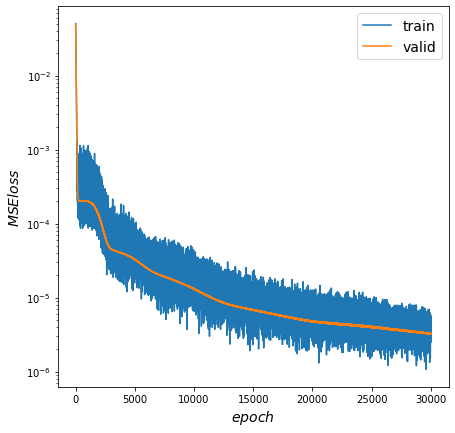

In [ ]:
fig = plt.figure(figsize=(7,7))
axe1 = plt.subplot(111)
axe1.semilogy(epoch_list,loss_list,label = "train")
axe1.semilogy(epoch_list,loss_valid,label = "valid")
axe1.legend(loc = "best",fontsize=14)
axe1.set_xlabel("$epoch$",fontsize=14)
axe1.set_ylabel("$MSE loss$",fontsize=14)


In [ ]:
S,x = S_Matrix()
print(x.shape)
print(total_pre.shape)
path = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/BE_pics/"
Save_pic(path,x,total_pre)